# Prédiction de la Consommation d’Énergie du Business Groupe à Ålesund

Ce notebook présente une approche complète pour améliorer la prédiction de la consommation énergétique d’un business group à Ålesund, en Norvège, à partir de données historiques. Il combine des techniques de prétraitement, d’ingénierie de variables, de normalisation, de modélisation séquentielle (LSTM) et d’analyse d’erreurs.

## Étapes principales du notebook

1. **Chargement et préparation des données**  
    - Import des bibliothèques nécessaires  
    - Chargement des données historiques  
    - Transformation des variables (création de la variable cible, gestion des dates, suppression des colonnes inutiles)

2. **Feature Engineering**  
    - Extraction de variables temporelles (heure, mois, jour de la semaine, etc.)  
    - Ajout d’une variable binaire pour les jours fériés en Norvège  
    - Encodage cyclique des variables temporelles

3. **Prétraitement**  
    - Analyse exploratoire (histogrammes, boxplots)  
    - Normalisation des variables numériques avec MinMaxScaler

4. **Préparation des séquences pour LSTM**  
    - Création de séquences temporelles pour l’apprentissage supervisé  
    - Séparation en ensembles d’entraînement et de test

5. **Modélisation**  
    - Construction et entraînement d’un modèle LSTM  
    - Construction d’un modèle hybride LSTM + autorégressif

6. **Évaluation et visualisation**  
    - Calcul du MAPE (Mean Absolute Percentage Error)  
    - Visualisation des prédictions vs valeurs réelles  
    - Analyse détaillée des erreurs par mois, jour, jour de la semaine  
    - Statistiques descriptives sur les performances du modèle

## Objectif

Fournir un pipeline reproductible pour la prévision de la consommation énergétique horaire, permettant d’identifier les périodes de meilleure et de moins bonne performance du modèle, et d’explorer l’impact des variables temporelles et calendaires.

---

**Auteur :**  
*MGHYLY Oumaima*

**Date :**  
*06/08/2025*

## Introduction

Prédiction de la consommation d’énergie du business groupe dans Alesund à partir des données historiques.

## Import des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   # For visualizations
from sklearn.preprocessing import MinMaxScaler  # For scaling features
from sklearn.preprocessing import StandardScaler   # For scaling features
import seaborn as sns  # For visualizations
import tensorflow as tf  # Import TensorFlow for LSTM
from tensorflow.keras.models import Sequential   # Sequential model for LSTM
from tensorflow.keras.layers import LSTM, Dense  # LSTM layer for time series
from tensorflow.keras.metrics import MeanAbsolutePercentageError   # For MAPE calculation
from tensorflow.keras.callbacks import ReduceLROnPlateau     # For learning rate reduction
from tensorflow.keras.optimizers import Adam   # Ensure reproducibility
from sklearn.metrics import mean_absolute_percentage_error
import random    # This import is used for random seed setting
import holidays  # For handling holidays in time series


## Chargement des données 

In [2]:
df_business_consumption=pd.read_csv('business_group_data.csv')  # Load the dataset

In [3]:
df_business_consumption['Date'] = pd.to_datetime(
    df_business_consumption['Date'])   # Convert 'Date' column to datetime format

In [4]:
# Création de la nouvelle colonne
df_business_consumption["Consommation"] = df_business_consumption["VOLUME_KWH"] / df_business_consumption["METERINGPOINT_COUNT"]

# Suppression des deux colonnes d'origine
df_business_consumption.drop(columns=["VOLUME_KWH", "METERINGPOINT_COUNT"], inplace=True)


## Feature engineering

In [5]:

# Extraire les composants de date
df_business_consumption['hour'] = df_business_consumption['Date'].dt.hour
df_business_consumption['month'] = df_business_consumption['Date'].dt.month
df_business_consumption['weekday'] = df_business_consumption['Date'].dt.weekday  # 0 = lundi, 6 = dimanche
df_business_consumption['dayofyear'] = df_business_consumption['Date'].dt.dayofyear

# Vérification
df_business_consumption.head()


,Date,wind_speed,t2m_C,surface_pressure,Consommation,hour,month,weekday,dayofyear
0,2021-01-01 00:00:00,2.798005,1.68923,98874.560,8.082154,0,1,4,1
1,2021-01-01 01:00:00,2.630726,1.32168,98905.060,8.021209,1,1,4,1
2,2021-01-01 02:00:00,2.387332,1.01553,98930.625,8.132821,2,1,4,1
3,2021-01-01 03:00:00,1.984651,0.77847,98928.000,8.151846,3,1,4,1
4,2021-01-01 04:00:00,1.515596,0.66543,98949.560,8.389451,4,1,4,1


In [6]:
df_business_consumption.drop(columns=["wind_speed","surface_pressure"], inplace=True)   # Suppression des colonnes inutiles

In [ ]:
import pandas as pd
import holidays  # Import holidays 

# Assurer que 'date' est bien en datetime
df_business_consumption['Date'] = pd.to_datetime(df_business_consumption['Date']) # Convertir la colonne 'Date' en datetime

# Extraire uniquement la date sans heure
df_business_consumption['date_only'] = df_business_consumption['Date'].dt.date

# Récupérer les jours fériés pour toutes les années de la base
norway_holidays = holidays.Norway(years=df_business_consumption['Date'].dt.year.unique())

# Créer la colonne binaire is_holiday
df_business_consumption['is_holiday'] = df_business_consumption['date_only'].isin(norway_holidays).astype(int)

# Supprimer la colonne temporaire si besoin
df_business_consumption.drop(columns=['date_only'], inplace=True)


In [8]:
df_business_consumption

,Date,t2m_C,Consommation,hour,month,weekday,dayofyear,is_holiday
0,2021-01-01 00:00:00,1.68923,8.082154,0,1,4,1,1
1,2021-01-01 01:00:00,1.32168,8.021209,1,1,4,1,1
2,2021-01-01 02:00:00,1.01553,8.132821,2,1,4,1,1
3,2021-01-01 03:00:00,0.77847,8.151846,3,1,4,1,1
4,2021-01-01 04:00:00,0.66543,8.389451,4,1,4,1,1
...,...,...,...,...,...,...,...,...
38457,2025-05-22 09:00:00,6.78066,12.467744,9,5,3,142,0
38458,2025-05-22 10:00:00,6.70490,12.329242,10,5,3,142,0
38459,2025-05-22 11:00:00,7.06533,12.227613,11,5,3,142,0
38460,2025-05-22 12:00:00,7.26953,11.912325,12,5,3,142,0


##  Prétraitement des données

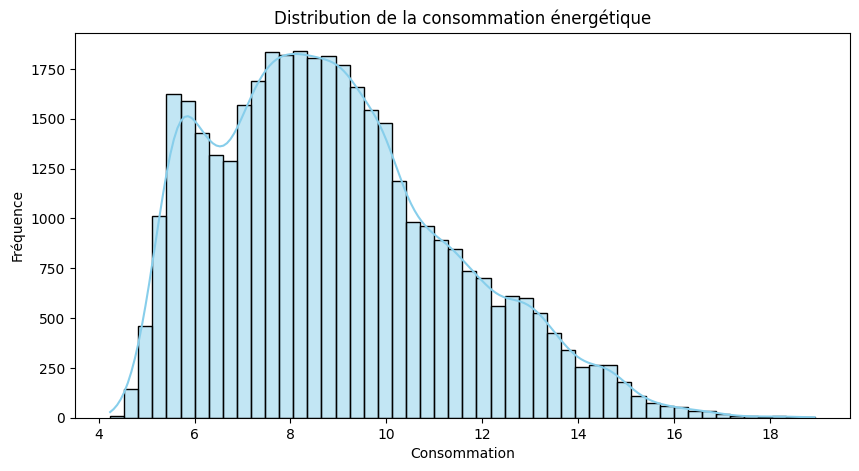

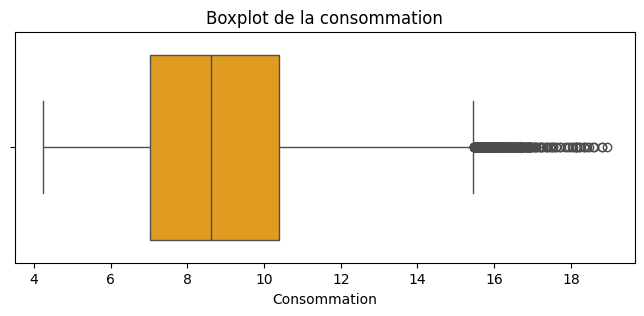

In [9]:

# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["Consommation"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la consommation énergétique")
plt.xlabel("Consommation")
plt.ylabel("Fréquence")
plt.show()

# Boxplot (pour voir les outliers)
plt.figure(figsize=(8, 3))
sns.boxplot(x=df_business_consumption["Consommation"], color="orange")
plt.title("Boxplot de la consommation")
plt.show()


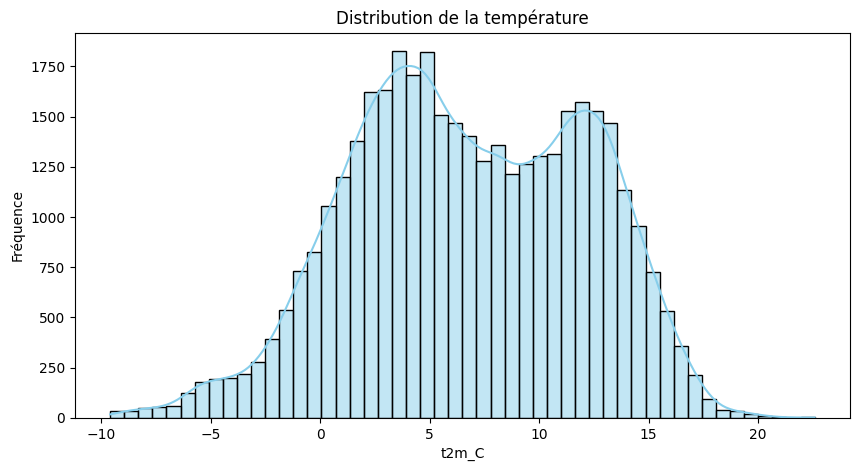

In [10]:
# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["t2m_C"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la température")
plt.xlabel("t2m_C")
plt.ylabel("Fréquence")
plt.show()

MinMaxScaler  il est plus adapté aux données asymétriques.

In [11]:

df_normalise=df_business_consumption.copy()  # Créer une copie du DataFrame pour la normalisation
# Liste des colonnes à normaliser
colonnes_a_normaliser = ["Consommation" , "t2m_C"]
scalers_minmax = {} # Dictionnaire pour stocker les scalers MinMax pour chaque colonne
for col in colonnes_a_normaliser:       # Normalisation Min-Max
    scaler = MinMaxScaler()
    df_normalise[col] = scaler.fit_transform(df_normalise[[col]])   # Fit and transform the column
    scalers_minmax[col] = scaler


In [12]:
# Encodage cyclique
df_normalise["hour_sin"] = np.sin(2 * np.pi * df_normalise["hour"] / 24)   # Encode hour as sine wave
df_normalise["hour_cos"] = np.cos(2 * np.pi * df_normalise["hour"] / 24)

df_normalise["month_sin"] = np.sin(2 * np.pi * df_normalise["month"] / 12)
df_normalise["month_cos"] = np.cos(2 * np.pi * df_normalise["month"] / 12)

df_normalise["weekday_sin"] = np.sin(2 * np.pi * df_normalise["weekday"] / 7)
df_normalise["weekday_cos"] = np.cos(2 * np.pi * df_normalise["weekday"] / 7)

df_normalise["dayofyear_sin"] = np.sin(2 * np.pi * df_normalise["dayofyear"] / 365)
df_normalise["dayofyear_cos"] = np.cos(2 * np.pi * df_normalise["dayofyear"] / 365)

In [13]:
df_normalise

,Date,t2m_C,Consommation,hour,month,weekday,dayofyear,is_holiday,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
0,2021-01-01 00:00:00,0.350590,0.261538,0,1,4,1,1,0.000000e+00,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
1,2021-01-01 01:00:00,0.339167,0.257389,1,1,4,1,1,2.588190e-01,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2,2021-01-01 02:00:00,0.329652,0.264986,2,1,4,1,1,5.000000e-01,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
3,2021-01-01 03:00:00,0.322284,0.266281,3,1,4,1,1,7.071068e-01,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
4,2021-01-01 04:00:00,0.318771,0.282455,4,1,4,1,1,8.660254e-01,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38457,2025-05-22 09:00:00,0.508829,0.560058,9,5,3,142,0,7.071068e-01,-0.707107,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38458,2025-05-22 10:00:00,0.506474,0.550630,10,5,3,142,0,5.000000e-01,-0.866025,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38459,2025-05-22 11:00:00,0.517676,0.543712,11,5,3,142,0,2.588190e-01,-0.965926,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38460,2025-05-22 12:00:00,0.524023,0.522251,12,5,3,142,0,1.224647e-16,-1.000000,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659


In [14]:
df_normalise.index=df_normalise['Date']  # Set 'Date' as index for time series analysis

df_normalise.drop(columns=["Date","hour", "month", "weekday", "dayofyear"], inplace=True)  # Drop original date and time columns

df_normalise.head()

,t2m_C,Consommation,is_holiday,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
Date,,,,,,,,,,,
2021-01-01 00:00:00,0.350590,0.261538,1,0.000000,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 01:00:00,0.339167,0.257389,1,0.258819,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 02:00:00,0.329652,0.264986,1,0.500000,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 03:00:00,0.322284,0.266281,1,0.707107,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 04:00:00,0.318771,0.282455,1,0.866025,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852


In [15]:
col = 'Consommation'
# Réorganiser les colonnes
df_normalise = df_normalise[[col] + [c for c in df_normalise.columns if c != col]]  # Réorganiser les colonnes pour que 'Consommation' soit en première position

In [16]:
df_normalise.head()

,Consommation,t2m_C,is_holiday,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
Date,,,,,,,,,,,
2021-01-01 00:00:00,0.261538,0.350590,1,0.000000,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 01:00:00,0.257389,0.339167,1,0.258819,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 02:00:00,0.264986,0.329652,1,0.500000,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 03:00:00,0.266281,0.322284,1,0.707107,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 04:00:00,0.282455,0.318771,1,0.866025,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852


## @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Séparation et entraînement

In [17]:
import numpy as np

sequence_length = 24  # Nombre de pas de temps dans chaque séquence
forecast_horizon = 24 # Nombre de pas de temps à prédire

def create_sequences(data, target_col, sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon):
        X.append(data.iloc[i:i+sequence_length].values)
        y.append(data.iloc[i+sequence_length:i+sequence_length+forecast_horizon][target_col].values)
    return np.array(X), np.array(y)


target_col = "Consommation"

In [18]:
X, y = create_sequences(df_normalise, target_col, sequence_length, forecast_horizon)  # Create sequences for the entire dataset

In [19]:
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [20]:
X_test_indices = [i for i in range(len(df_normalise) - sequence_length - forecast_horizon)][-len(X_test):]

In [21]:
model = Sequential([
    LSTM(64,  return_sequences=True, dropout=0.1, recurrent_dropout=0.1, input_shape=(sequence_length, X.shape[2])),  # 1re couche LSTM
    LSTM(32, dropout=0.1, recurrent_dropout=0.1,  return_sequences=False),  # 2e couche LSTM
    
    Dense(forecast_horizon, activation='linear')  # 24 sorties pour les 24 heures futures
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[MeanAbsolutePercentageError()])


model.summary()

c:\Users\emac\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,664 (127.59 KB)

 Trainable params: 32,664 (127.59 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(X_train, y_train, epochs=40, batch_size=30,  validation_data=(X_test, y_test),
verbose=1)

Epoch 1/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - loss: 0.0258 - mean_absolute_percentage_error: 47.1415 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 14034.5078
Epoch 2/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 31s 30ms/step - loss: 0.0079 - mean_absolute_percentage_error: 29.5414 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 14348.6016
Epoch 3/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - loss: 0.0062 - mean_absolute_percentage_error: 25.8011 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 12677.8721
Epoch 4/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - loss: 0.0053 - mean_absolute_percentage_error: 23.5921 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 11398.3906
Epoch 5/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - loss: 0.0047 - mean_absolute_percentage_error: 21.8872 - val_loss: 0.0038 - val_mean_absolute_percentage_error: 11511.6035
Epoch 6/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 29s 28ms/step - loss: 0.0043 - mean_absolute_percenta

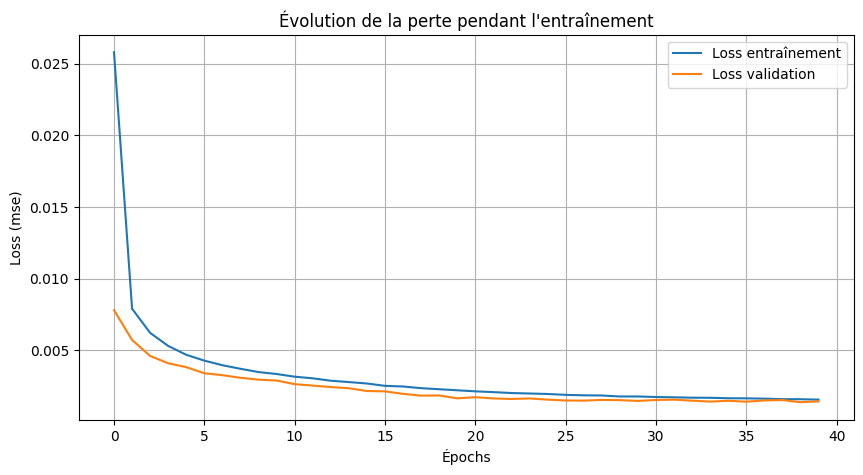

In [23]:
# Affichage de la loss d'entraînement et de validation
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss entraînement')
plt.plot(history.history['val_loss'], label='Loss validation')
plt.xlabel('Épochs')
plt.ylabel('Loss (mse)')
plt.title('Évolution de la perte pendant l\'entraînement')
plt.legend()
plt.grid(True)
plt.show()

241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


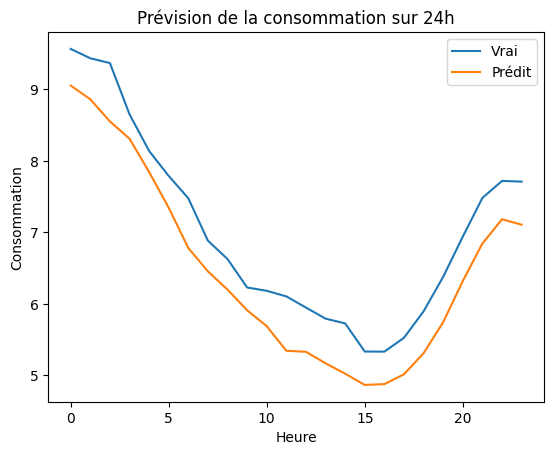

In [24]:

y_pred = model.predict(X_test)

#  inverser la normalisation
y_pred_inversed = scalers_minmax['Consommation'].inverse_transform(y_pred)
y_test_inversed = scalers_minmax['Consommation'].inverse_transform(y_test)

# Visualisation
plt.plot(y_test_inversed[0], label='Vrai')
plt.plot(y_pred_inversed[0], label='Prédit')
plt.legend()
plt.title("Prévision de la consommation sur 24h")
plt.xlabel("Heure")
plt.ylabel("Consommation")
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_percentage_error

test_mape = mean_absolute_percentage_error(y_test_inversed, y_pred_inversed) * 100
print(f"Test MAPE: {test_mape:.2f}%")

Test MAPE: 4.30%


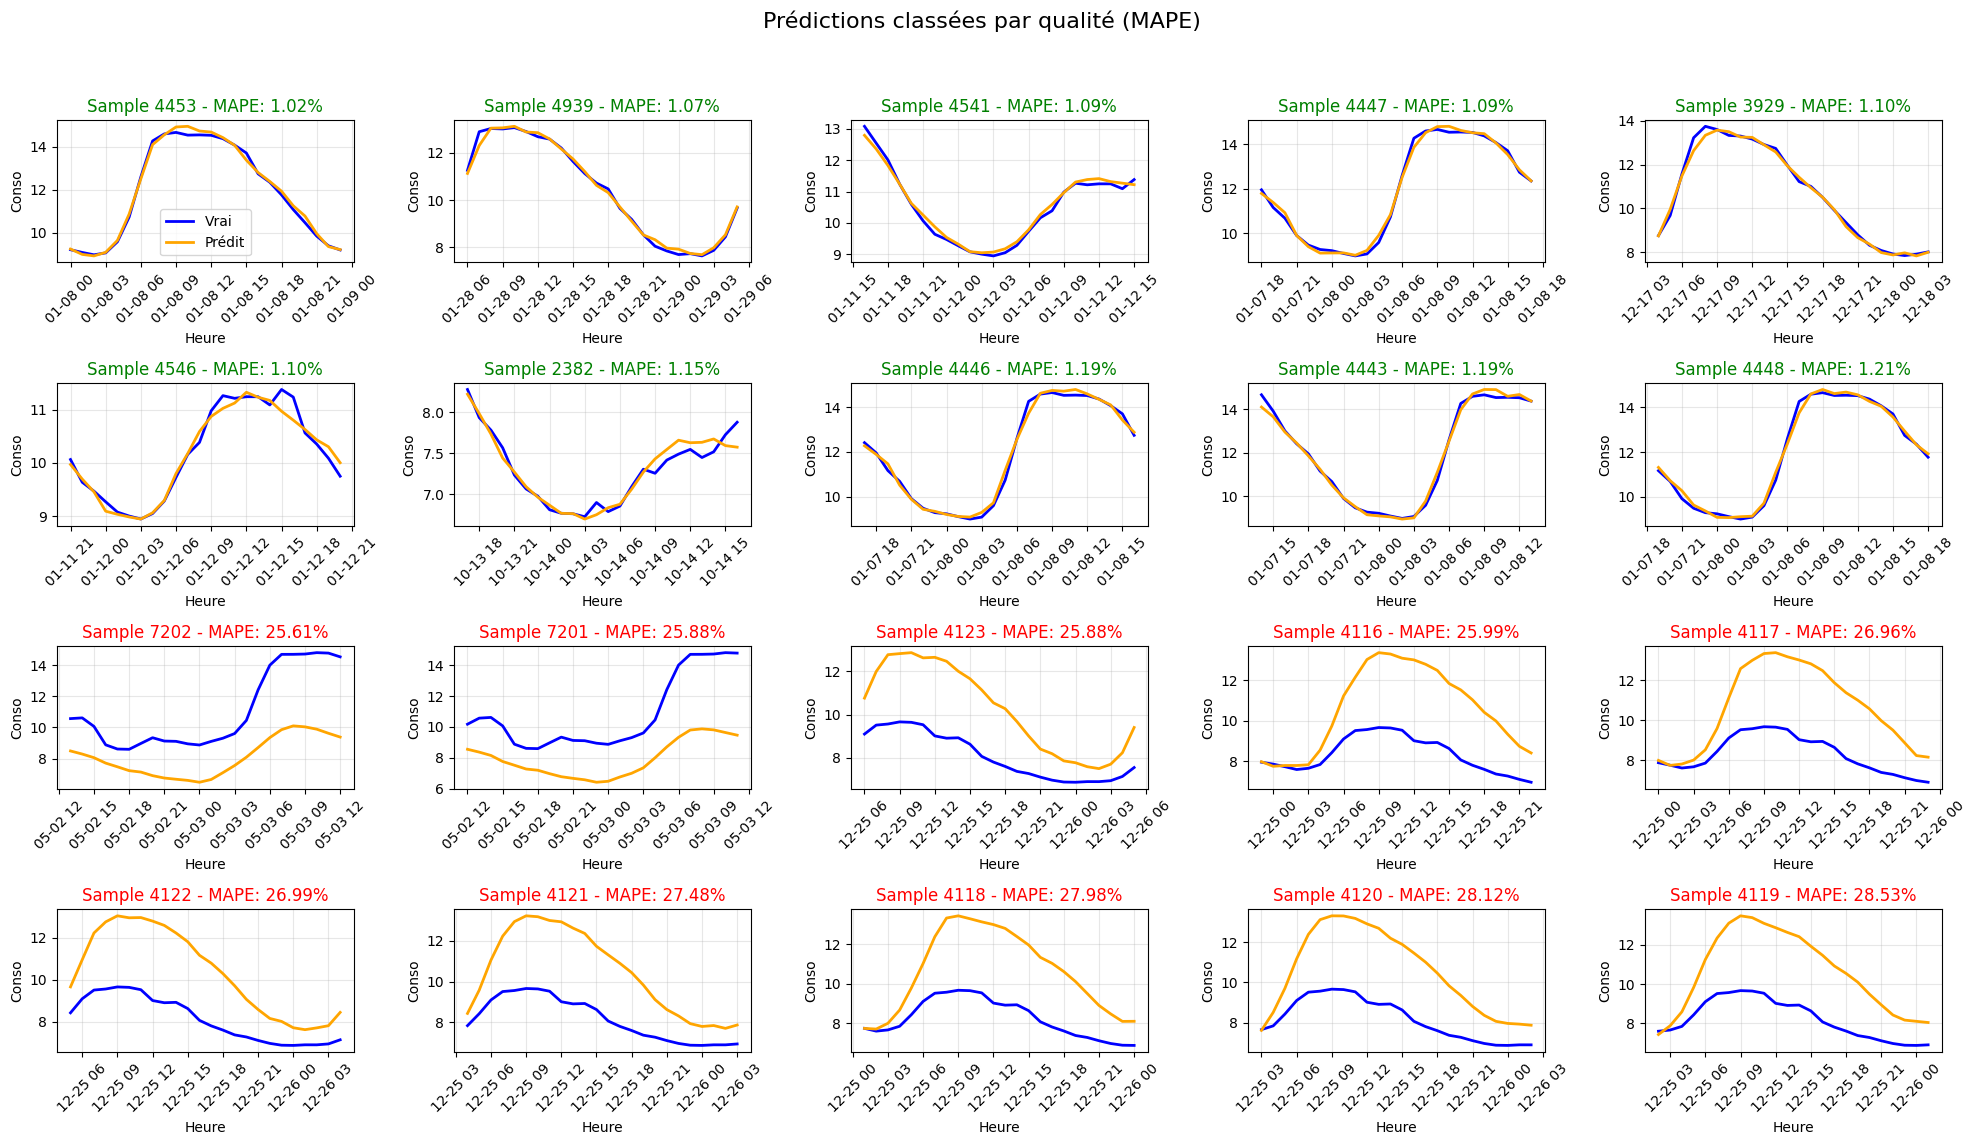

In [26]:



def safe_mape(y_true, y_pred):
    """MAPE qui évite la division par zéro"""
    mask = y_true != 0
    if mask.sum() == 0:
        return 0
    return mean_absolute_percentage_error(y_true[mask], y_pred[mask]) * 100

# Vérifications
assert len(y_test_inversed) == len(y_pred_inversed)

# Calcul MAPE
mape_scores = [safe_mape(y_test_inversed[i], y_pred_inversed[i]) for i in range(len(y_test_inversed))]
sorted_indices = np.argsort(mape_scores)

# Sélection des échantillons
n_samples = min(10, len(y_test_inversed) // 2)    # Nombre d'échantillons à afficher (10 ou la moitié de l'ensemble de test) minimum of the two
best_indices = sorted_indices[:n_samples]   # Indices des meilleurs échantillons
worst_indices = sorted_indices[-n_samples:]          # Indices des pires échantillons
indices_to_plot = np.concatenate([best_indices, worst_indices])   # Combine best and worst indices for plotting

# Timestamps
try:
    timestamps = df_normalise.index[sequence_length + forecast_horizon:]
    timestamps_test = timestamps[X_test_indices]
    use_timestamps = True
except:
    print("Utilisation d'indices simples pour les timestamps")
    use_timestamps = False

# Visualisation
n_plots = len(indices_to_plot)       # Total number of plots to display
n_cols = 5
n_rows = (n_plots + n_cols - 1) // n_cols    # Calculate number of rows needed for the plots

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
fig.suptitle("Prédictions classées par qualité (MAPE)", fontsize=16)

# S'assurer que axes est un array 2D
if n_rows == 1:
    axes = axes.reshape(1, -1)

for i, idx in enumerate(indices_to_plot):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]
    
    # Axe X
    if use_timestamps:
        start_time = timestamps_test[idx]
        hours = [start_time + pd.Timedelta(hours=h) for h in range(forecast_horizon)]
        ax.plot(hours, y_test_inversed[idx], label='Vrai', color='blue', linewidth=2)
        ax.plot(hours, y_pred_inversed[idx], label='Prédit', color='orange', linewidth=2)
        ax.tick_params(axis='x', rotation=45)
    else:
        hours = range(forecast_horizon)
        ax.plot(hours, y_test_inversed[idx], label='Vrai', color='blue', linewidth=2)
        ax.plot(hours, y_pred_inversed[idx], label='Prédit', color='orange', linewidth=2)
    
    # Titres et labels
    color = 'green' if i < n_samples else 'red'  # Vert pour les meilleurs, rouge pour les pires
    ax.set_title(f"Sample {idx} - MAPE: {mape_scores[idx]:.2f}%", color=color)
    ax.set_xlabel("Heure")
    ax.set_ylabel("Conso")
    ax.grid(True, alpha=0.3)
    
    # Légende seulement sur le premier graphique
    if i == 0:
        ax.legend()

# Masquer les subplots vides
for i in range(n_plots, n_rows * n_cols):
    row, col = divmod(i, n_cols)
    axes[row, col].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Aucun échantillon pour la tranche '< 1%'


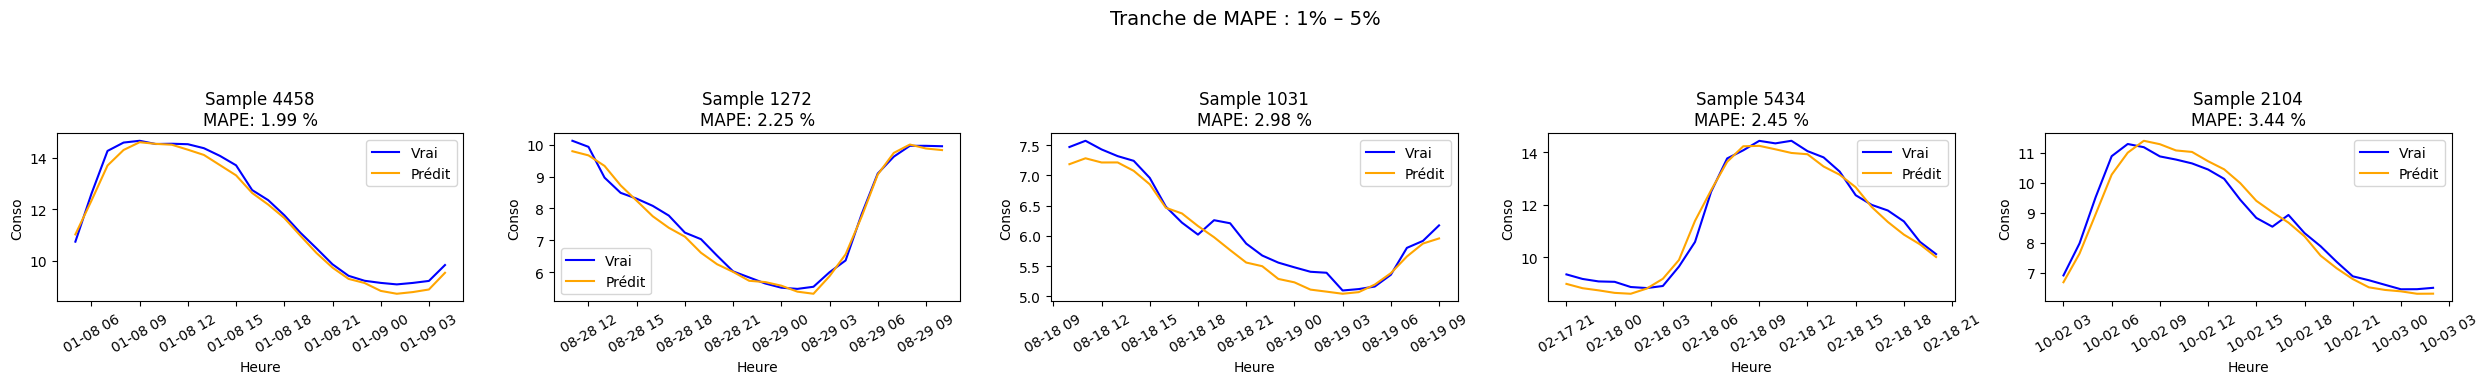

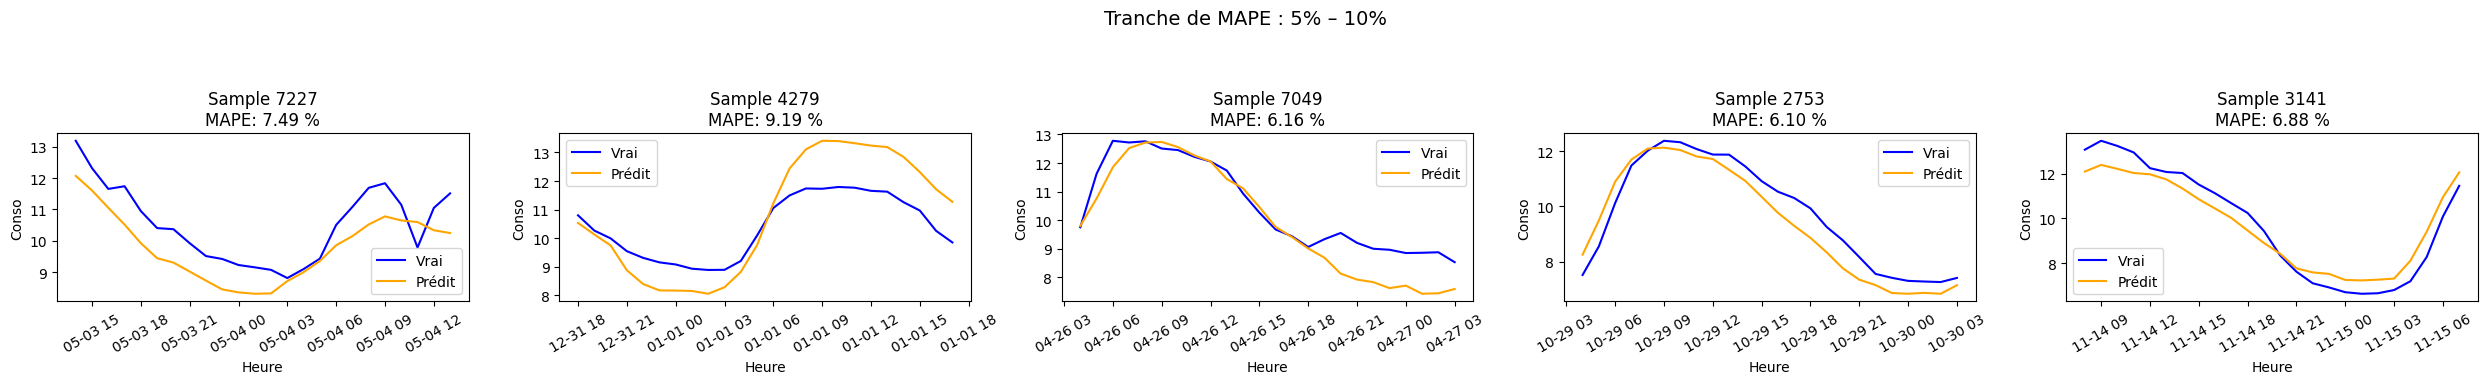

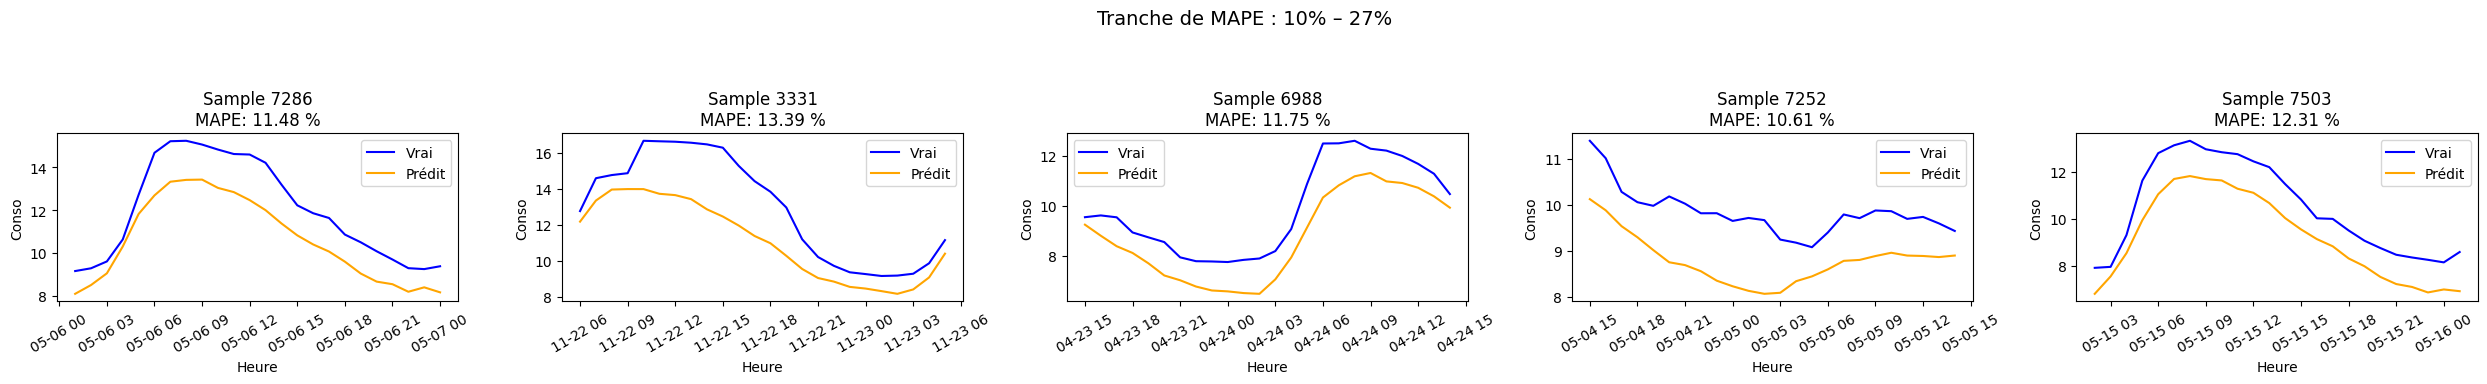

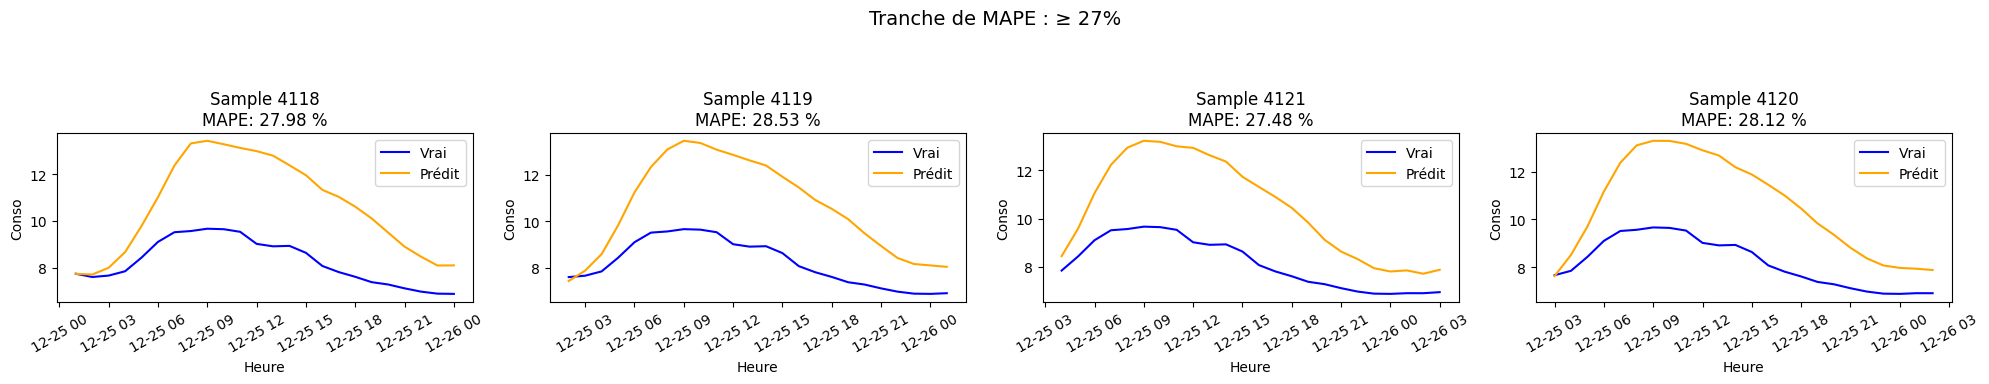

In [27]:

# Calcul des MAPE
mape_scores = [mean_absolute_percentage_error(y_test_inversed[i], y_pred_inversed[i]) * 100 for i in range(len(y_test_inversed))]
 
# Tranches de MAPE
mape_bins = {
    "< 1%": [],  # Tranche pour MAPE < 1%
    "1% – 5%": [],     
    "5% – 10%": [],
    "10% – 27%": [],
    "≥ 27%": []
}
 
# Répartition des indices dans chaque tranche
for i, mape in enumerate(mape_scores):
    if mape < 1:
        mape_bins["< 1%"].append(i)    # Tranche pour MAPE < 1%
    elif mape < 5:
        mape_bins["1% – 5%"].append(i)
    elif mape < 10 :
        mape_bins["5% – 10%"].append(i)
    elif mape < 27 :
        mape_bins["10% – 27%"].append(i)
    else:
        mape_bins["≥ 27%"].append(i)
 
# Timestamps
try:
    timestamps = df_normalise.index[sequence_length + forecast_horizon:]
    timestamps_test = timestamps[X_test_indices]
    use_timestamps = True
except:
    print("Utilisation d'indices simples pour les timestamps")
    use_timestamps = False
 
# Affichage : 5 graphes par tranche
for category, indices in mape_bins.items():
    if len(indices) == 0:
        print(f"Aucun échantillon pour la tranche '{category}'")   # Skip if no samples in this category
        continue
 
    sample_indices = random.sample(indices, min(5, len(indices)))   # Sélection aléatoire de 5 échantillons ou moins si moins d'échantillons disponibles
 
    fig, axes = plt.subplots(1, len(sample_indices), figsize=(5 * len(sample_indices), 4))      # Create subplots for each sample
    fig.suptitle(f"Tranche de MAPE : {category}", fontsize=14)       # Title for the entire figure
 
    # S'assurer que axes est itérable
    if len(sample_indices) == 1:
        axes = [axes]
 
    for ax, idx in zip(axes, sample_indices):
        start_time = timestamps_test[idx]
        hours = [start_time + pd.Timedelta(hours=h) for h in range(forecast_horizon)]   # Generate hours for the x-axis
 
        ax.plot(hours, y_test_inversed[idx], label='Vrai', color='blue')
        ax.plot(hours, y_pred_inversed[idx], label='Prédit', color='orange')
        ax.set_title(f"Sample {idx}\nMAPE: {mape_scores[idx]:.2f} %")
        ax.set_xlabel("Heure")
        ax.set_ylabel("Conso")
        ax.xaxis.set_tick_params(rotation=30)
 
        ax.legend()
 
    plt.tight_layout(rect=[0, 0.03, 1, 0.90])
    plt.show()

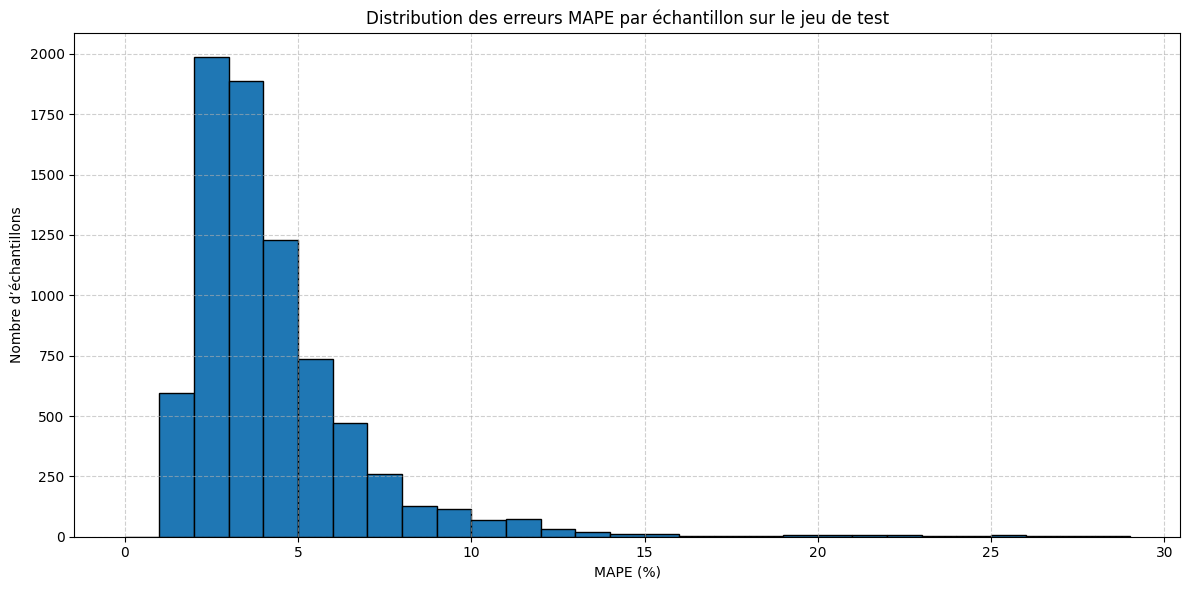

In [28]:

# Calcul du MAPE par échantillon
# Ici, on calcule le MAPE pour chaque échantillon et chaque horizon de prédiction
# puis on fait la moyenne sur l'horizon pour obtenir un score par échantillon
mape_per_sample = np.mean(np.abs((y_test_inversed - y_pred_inversed) / (y_test_inversed + 1e-8)) * 100, axis=1)

#  Regroupement des MAPE en intervalles (bins)
bins = np.arange(0, np.ceil(mape_per_sample.max()) +1 , 1)

# Tracer l’histogramme
plt.figure(figsize=(12, 6))
plt.hist(mape_per_sample, bins=bins, edgecolor='black')
plt.xlabel("MAPE (%)")
plt.ylabel("Nombre d’échantillons")
plt.title("Distribution des erreurs MAPE par échantillon sur le jeu de test")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [29]:
dates_test = df_business_consumption.loc[X_test_indices, "Date"]     # Get the dates corresponding to the test set indices

C:\Users\emac\AppData\Local\Temp\ipykernel_1196\3364321957.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby("MAPE_bin").size()


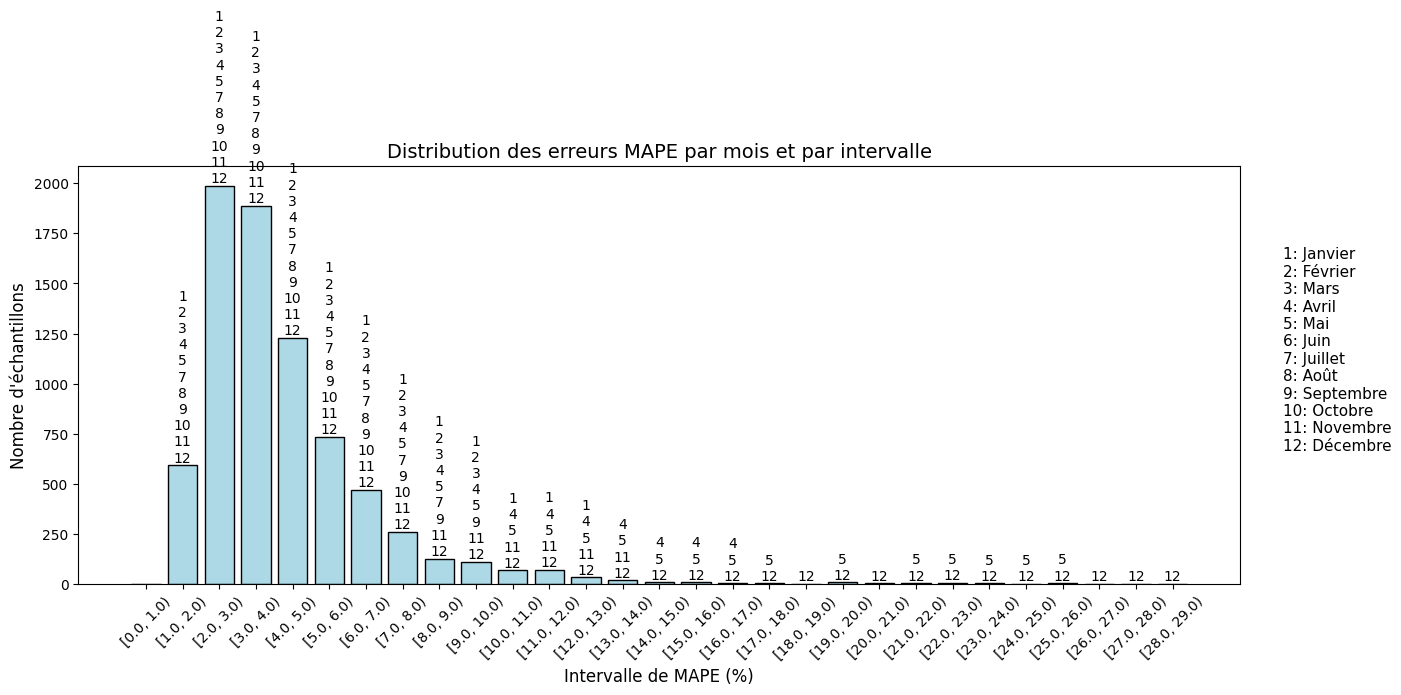

In [30]:
# Convertir timestamps en datetime si ce n'est pas déjà fait
timestamps_test = pd.to_datetime(timestamps_test)

#  Pour chaque timestamp, extraire tous les mois couverts par l'horizon de 24h
mois_par_sample = []
for t in timestamps_test:
    # Générer la série horaire pour l'horizon
    dates_horizon = pd.date_range(start=t, periods=forecast_horizon, freq='h')
    # Extraire les mois uniques
    mois = dates_horizon.month.unique()
    mois_par_sample.append(mois)

#  Créer les intervalles de MAPE (par exemple 1%)
bins = np.arange(0, np.ceil(mape_per_sample.max()) + 1, 1)

#  Construire DataFrame
df = pd.DataFrame({
    "MAPE": mape_per_sample,
    "Mois": mois_par_sample
})
df["MAPE_bin"] = pd.cut(df["MAPE"], bins=bins, right=False)

#  Grouper par bin pour compter les échantillons
df_grouped = df.groupby("MAPE_bin").size()

#  Plot
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(df_grouped.index.astype(str), df_grouped.values, edgecolor='black', color='lightblue')

#  Ajouter tous les mois (aplatir les listes) au-dessus des barres
for i, bin_label in enumerate(df_grouped.index):
    mois_listes = df.loc[df["MAPE_bin"] == bin_label, "Mois"]
    # Aplatir les listes et extraire les mois uniques
    tous_les_mois = sorted(set(m for sous_liste in mois_listes for m in sous_liste))
    mois_str = "\n".join(str(m) for m in tous_les_mois)
    ax.text(i, df_grouped.values[i] + 1, mois_str, ha='center', va='bottom', fontsize=10, color='black')

#  Mise en forme
ax.set_title("Distribution des erreurs MAPE par mois et par intervalle", fontsize=14)
ax.set_xlabel("Intervalle de MAPE (%)", fontsize=12)
ax.set_ylabel("Nombre d'échantillons", fontsize=12)
plt.xticks(rotation=45)

# Légende mois à droite
mois_legende = "\n".join([
    "1: Janvier", "2: Février", "3: Mars", "4: Avril",
    "5: Mai", "6: Juin", "7: Juillet", "8: Août",
    "9: Septembre", "10: Octobre", "11: Novembre", "12: Décembre"
])
plt.gcf().text(0.92, 0.5, mois_legende, fontsize=11, va='center')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

C:\Users\emac\AppData\Local\Temp\ipykernel_1196\2631605013.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby("MAPE_bin").size()


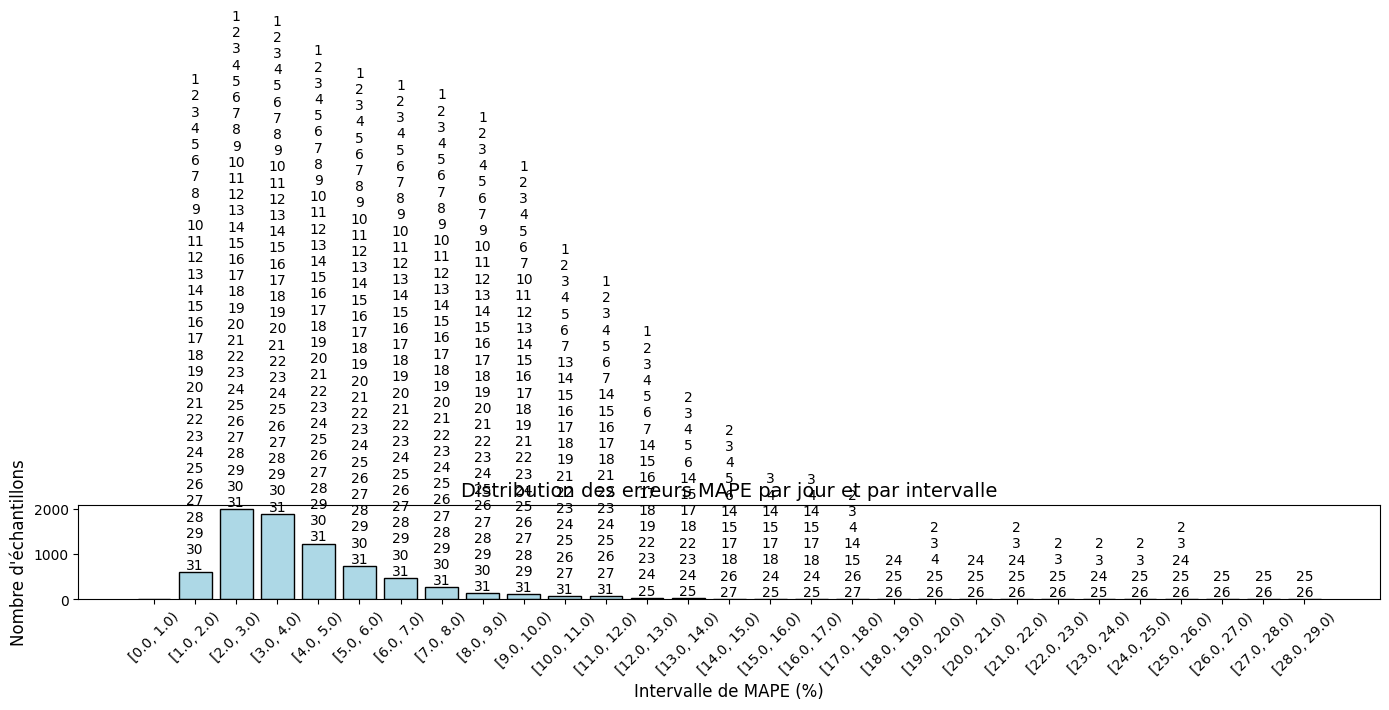

In [31]:


timestamps_test = pd.to_datetime(timestamps_test)

# Extraire tous les jours (numéro du jour dans le mois) couverts par chaque horizon
jours_par_sample = []
for t in timestamps_test:
    dates_horizon = pd.date_range(start=t, periods=forecast_horizon, freq='h')
    jours = dates_horizon.day.unique()  # jours dans le mois
    jours_par_sample.append(jours)

# Intervalles de MAPE (ajuste selon ton max MAPE)
bins = np.arange(0, np.ceil(mape_per_sample.max()) + 1, 1)

# DataFrame avec MAPE et jours multiples
df = pd.DataFrame({
    "MAPE": mape_per_sample,
    "Jours": jours_par_sample
})
df["MAPE_bin"] = pd.cut(df["MAPE"], bins=bins, right=False)

# Compter les échantillons par intervalle
df_grouped = df.groupby("MAPE_bin").size()

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(df_grouped.index.astype(str), df_grouped.values, edgecolor='black', color='lightblue')

# Ajouter les jours uniques au-dessus des barres
for i, bin_label in enumerate(df_grouped.index):
    jours_listes = df.loc[df["MAPE_bin"] == bin_label, "Jours"]
    tous_les_jours = sorted(set(j for sous_liste in jours_listes for j in sous_liste))
    jours_str = "\n".join(str(j) for j in tous_les_jours)
    ax.text(i, df_grouped.values[i] + 1, jours_str, ha='center', va='bottom', fontsize=10, color='black')

# Mise en forme
ax.set_title("Distribution des erreurs MAPE par jour et par intervalle", fontsize=14)
ax.set_xlabel("Intervalle de MAPE (%)", fontsize=12)
ax.set_ylabel("Nombre d'échantillons", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


C:\Users\emac\AppData\Local\Temp\ipykernel_1196\2188255723.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby("MAPE_bin").size()


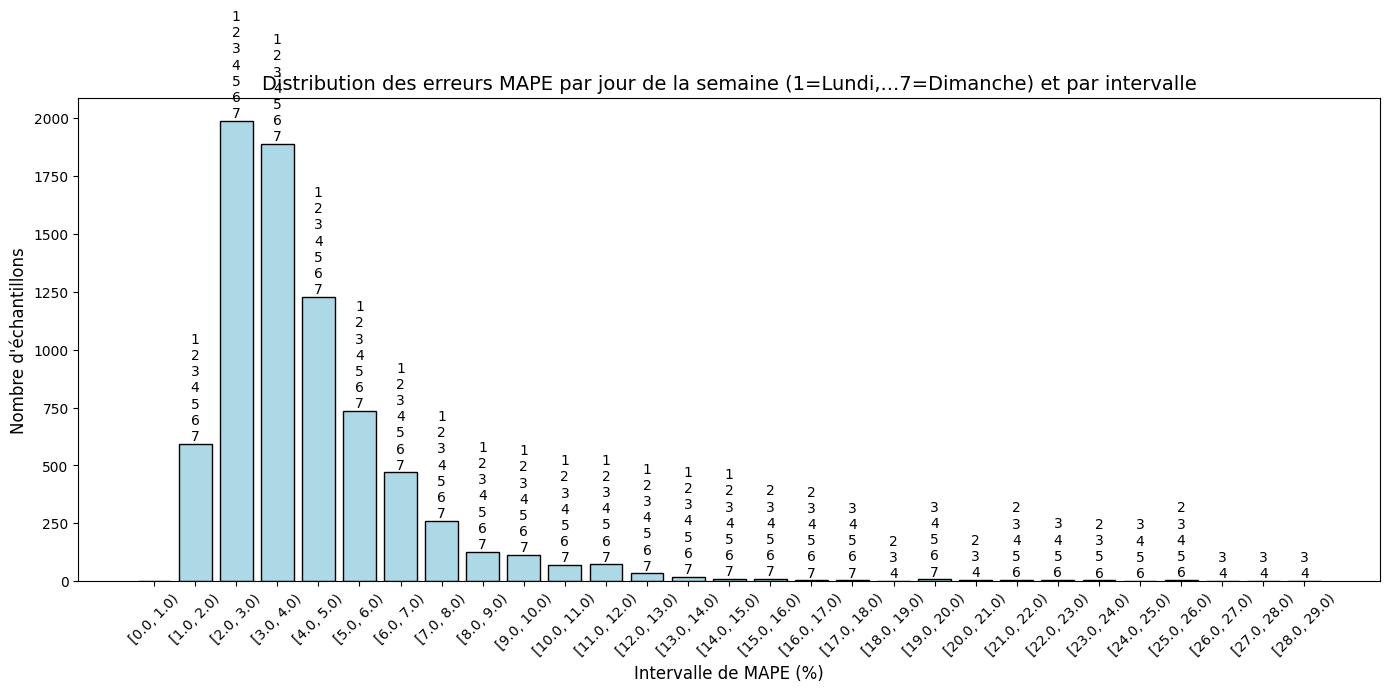

In [32]:


timestamps_test = pd.to_datetime(timestamps_test)    # Convertir les timestamps en datetime si ce n'est pas déjà fait

# Extraire les jours de la semaine couverts par chaque horizon (1=Lundi ... 7=Dimanche)
jours_sem_par_sample = []
for t in timestamps_test:
    dates_horizon = pd.date_range(start=t, periods=forecast_horizon, freq='h')
    jours_idx = dates_horizon.dayofweek.unique()  # 0=Lundi ... 6=Dimanche
    # Convertir en 1-7
    jours_chiffres = [j + 1 for j in jours_idx]
    jours_sem_par_sample.append(jours_chiffres)

# Intervalles de MAPE
bins = np.arange(0, np.ceil(mape_per_sample.max()) + 1, 1)

# DataFrame avec MAPE et jours de la semaine multiples
df = pd.DataFrame({
    "MAPE": mape_per_sample,
    "Jours_semaine": jours_sem_par_sample
})
df["MAPE_bin"] = pd.cut(df["MAPE"], bins=bins, right=False)

# Compter les échantillons par intervalle
df_grouped = df.groupby("MAPE_bin").size()

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(df_grouped.index.astype(str), df_grouped.values, edgecolor='black', color='lightblue')

# Ajouter les jours de la semaine uniques (chiffres) au-dessus des barres
for i, bin_label in enumerate(df_grouped.index):
    jours_listes = df.loc[df["MAPE_bin"] == bin_label, "Jours_semaine"]
    tous_les_jours = sorted(set(j for sous_liste in jours_listes for j in sous_liste))
    jours_str = "\n".join(str(j) for j in tous_les_jours)
    ax.text(i, df_grouped.values[i] + 1, jours_str, ha='center', va='bottom', fontsize=10, color='black')

# Mise en forme
ax.set_title("Distribution des erreurs MAPE par jour de la semaine (1=Lundi,...7=Dimanche) et par intervalle", fontsize=14)  
ax.set_xlabel("Intervalle de MAPE (%)", fontsize=12)
ax.set_ylabel("Nombre d'échantillons", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [33]:
# Analyse des résultats obtenus
# On les aplatit pour comparer globalement les distributions
y_test_flat = y_test_inversed.flatten()
y_pred_flat = y_pred_inversed.flatten()

# Création d'un DataFrame pour faciliter la comparaison
df_stats = pd.DataFrame({
    'Réel (y_test)': y_test_flat,
    'Prédit (y_pred)': y_pred_flat,
    'Erreur absolue': np.abs(y_test_flat - y_pred_flat),
    'Erreur relative (%)': 100 * np.abs(y_test_flat - y_pred_flat) / y_test_flat
})

# Calcul des statistiques descriptives
summary_stats = df_stats[['Réel (y_test)', 'Prédit (y_pred)', 'Erreur absolue', 'Erreur relative (%)']].describe().T
summary_stats = summary_stats.rename(columns={
    'mean': 'Moyenne',
    'std': 'Écart-type',
    'min': 'Min',
    '25%': 'Q1',
    '50%': 'Médiane',
    '75%': 'Q3',
    'max': 'Max'
})

# Affichage du tableau
print("Résumé statistique comparatif entre y_test et y_pred :")
display(summary_stats.round(2))


Résumé statistique comparatif entre y_test et y_pred :


,count,Moyenne,Écart-type,Min,Q1,Médiane,Q3,Max
Réel (y_test),184392.0,8.83,2.30,4.24,7.13,8.49,10.32,16.66
Prédit (y_pred),184392.0,8.69,2.19,4.58,7.06,8.38,10.11,15.77
Erreur absolue,184392.0,0.39,0.40,0.00,0.13,0.28,0.52,5.33
Erreur relative (%),184392.0,4.30,3.95,0.00,1.63,3.43,5.88,52.28


### @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Modèle hybride 

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Add, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsolutePercentageError
import tensorflow as tf

# Définir l'entrée
input_layer = Input(shape=(sequence_length, X.shape[2]))

# Branche LSTM (inchangée)
lstm1 = LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(input_layer)
lstm2 = LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=False)(lstm1)
lstm_output = Dense(forecast_horizon, activation='linear', name='lstm_branch')(lstm2)

# Branche AUTOREGRESSIVE (AR) - Vrai modèle autorégressif
# Prendre seulement les dernières valeurs pour l'autorégression
# Pour un modèle AR(p), on utilise les p dernières valeurs
ar_order = min(forecast_horizon, sequence_length)  # Ordre du modèle AR

# Extraire les dernières valeurs pour chaque feature
ar_input = Lambda(lambda x: x[:, -ar_order:, :])(input_layer)

# Aplatir pour le modèle linéaire AR
ar_flattened = Lambda(lambda x: tf.reshape(x, [-1, ar_order * x.shape[-1]]))(ar_input)

# Modèle autorégressif linéaire : y_t = c + φ1*y_{t-1} + φ2*y_{t-2} + ... + φp*y_{t-p}
# Une couche Dense sans activation (linéaire) pour implémenter l'AR
ar_output = Dense(forecast_horizon, activation='linear', name='ar_branch', 
                 use_bias=True)(ar_flattened)  # use_bias=True pour le terme constant 'c'

# Combiner LSTM + Modèle Autorégressif
combined_output = Add()([lstm_output, ar_output])

# Créer le modèle
model = Model(inputs=input_layer, outputs=combined_output)

# Compilation
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[MeanAbsolutePercentageError()])

model.summary()

# Entraînement
history = model.fit(X_train, y_train,
                   epochs=40,
                   batch_size=30,  
                   validation_data=(X_test, y_test),
                   verbose=1)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 24, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 24, 64)    │     19,456 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 24, 11)    │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 32)        │     12,416 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 264)       │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_branch (Dense) │ (None, 24)        │        792 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ar_branch (Dense)   │ (None, 24)        │      6,360 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24)        │          0 │ lstm_branch[0][0… │
│                     │                   │            │ ar_branch[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,024 (152.44 KB)

 Trainable params: 39,024 (152.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - loss: 0.0918 - mean_absolute_percentage_error: 87.4128 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 13897.6562
Epoch 2/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.0143 - mean_absolute_percentage_error: 41.6431 - val_loss: 0.0095 - val_mean_absolute_percentage_error: 10755.1113
Epoch 3/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.0094 - mean_absolute_percentage_error: 33.4431 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 9882.1211
Epoch 4/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.0071 - mean_absolute_percentage_error: 28.8100 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 8355.9180
Epoch 5/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.0057 - mean_absolute_percentage_error: 25.5738 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 8520.2783
Epoch 6/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.0047 - mean_absolute_percentage_

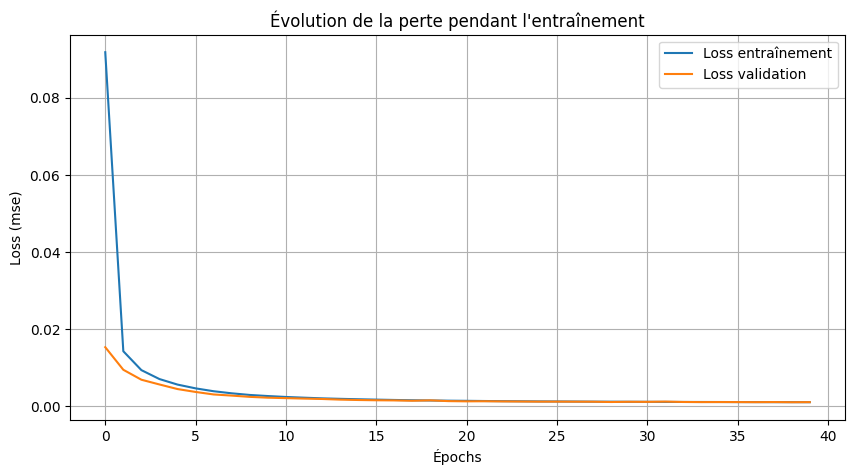

In [47]:
# Affichage de la loss d'entraînement et de validation
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss entraînement')
plt.plot(history.history['val_loss'], label='Loss validation')
plt.xlabel('Épochs')
plt.ylabel('Loss (mse)')
plt.title('Évolution de la perte pendant l\'entraînement')
plt.legend()
plt.grid(True)
plt.show()

241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


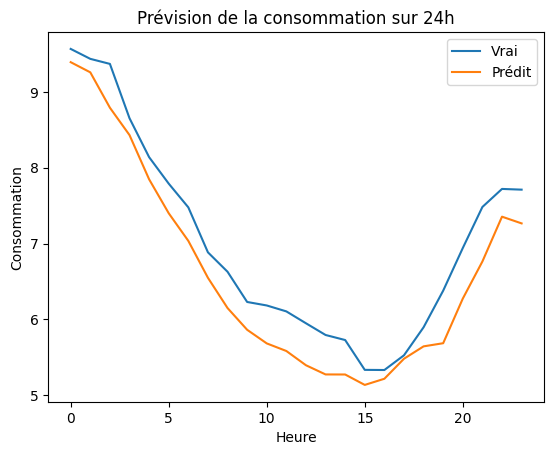

In [48]:

y_pred = model.predict(X_test)

#  inverser la normalisation
y_pred_inversed = scalers_minmax['Consommation'].inverse_transform(y_pred)
y_test_inversed = scalers_minmax['Consommation'].inverse_transform(y_test)

# Visualisation
plt.plot(y_test_inversed[0], label='Vrai')
plt.plot(y_pred_inversed[0], label='Prédit')
plt.legend()
plt.title("Prévision de la consommation sur 24h")
plt.xlabel("Heure")
plt.ylabel("Consommation")
plt.show()

In [49]:
from sklearn.metrics import mean_absolute_percentage_error

test_mape = mean_absolute_percentage_error(y_test_inversed, y_pred_inversed) * 100
print(f"Test MAPE: {test_mape:.2f}%")

Test MAPE: 3.76%


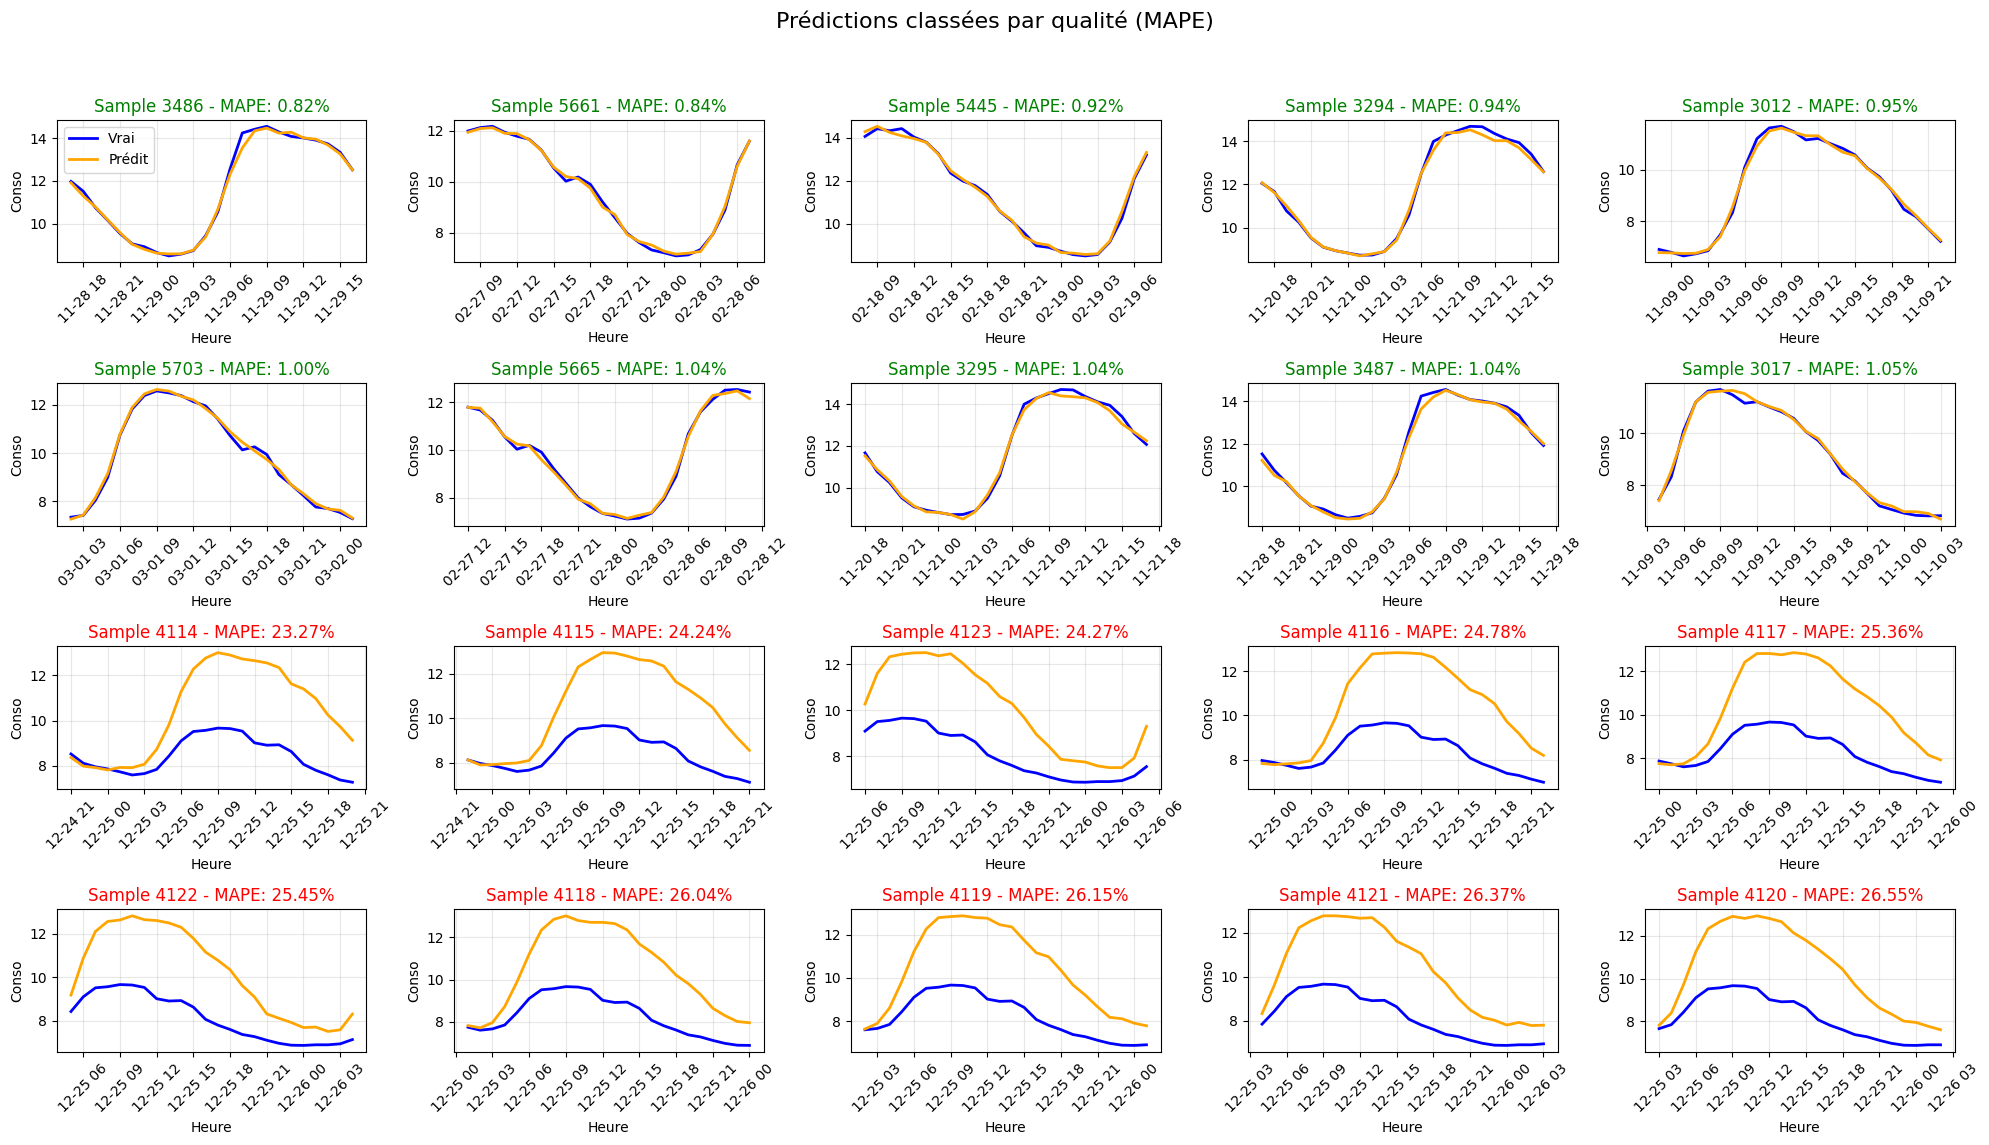

In [50]:



def safe_mape(y_true, y_pred):
    """MAPE qui évite la division par zéro"""
    mask = y_true != 0
    if mask.sum() == 0:
        return 0
    return mean_absolute_percentage_error(y_true[mask], y_pred[mask]) * 100

# Vérifications
assert len(y_test_inversed) == len(y_pred_inversed)

# Calcul MAPE
mape_scores = [safe_mape(y_test_inversed[i], y_pred_inversed[i]) for i in range(len(y_test_inversed))]
sorted_indices = np.argsort(mape_scores)

# Sélection des échantillons
n_samples = min(10, len(y_test_inversed) // 2)    # Nombre d'échantillons à afficher (10 ou la moitié de l'ensemble de test) minimum of the two
best_indices = sorted_indices[:n_samples]   # Indices des meilleurs échantillons
worst_indices = sorted_indices[-n_samples:]          # Indices des pires échantillons
indices_to_plot = np.concatenate([best_indices, worst_indices])   # Combine best and worst indices for plotting

# Timestamps
try:
    timestamps = df_normalise.index[sequence_length + forecast_horizon:]
    timestamps_test = timestamps[X_test_indices]
    use_timestamps = True
except:
    print("Utilisation d'indices simples pour les timestamps")
    use_timestamps = False

# Visualisation
n_plots = len(indices_to_plot)       # Total number of plots to display
n_cols = 5
n_rows = (n_plots + n_cols - 1) // n_cols    # Calculate number of rows needed for the plots

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
fig.suptitle("Prédictions classées par qualité (MAPE)", fontsize=16)

# S'assurer que axes est un array 2D
if n_rows == 1:
    axes = axes.reshape(1, -1)

for i, idx in enumerate(indices_to_plot):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]
    
    # Axe X
    if use_timestamps:
        start_time = timestamps_test[idx]
        hours = [start_time + pd.Timedelta(hours=h) for h in range(forecast_horizon)]
        ax.plot(hours, y_test_inversed[idx], label='Vrai', color='blue', linewidth=2)
        ax.plot(hours, y_pred_inversed[idx], label='Prédit', color='orange', linewidth=2)
        ax.tick_params(axis='x', rotation=45)
    else:
        hours = range(forecast_horizon)
        ax.plot(hours, y_test_inversed[idx], label='Vrai', color='blue', linewidth=2)
        ax.plot(hours, y_pred_inversed[idx], label='Prédit', color='orange', linewidth=2)
    
    # Titres et labels
    color = 'green' if i < n_samples else 'red'  # Vert pour les meilleurs, rouge pour les pires
    ax.set_title(f"Sample {idx} - MAPE: {mape_scores[idx]:.2f}%", color=color)
    ax.set_xlabel("Heure")
    ax.set_ylabel("Conso")
    ax.grid(True, alpha=0.3)
    
    # Légende seulement sur le premier graphique
    if i == 0:
        ax.legend()

# Masquer les subplots vides
for i in range(n_plots, n_rows * n_cols):
    row, col = divmod(i, n_cols)
    axes[row, col].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

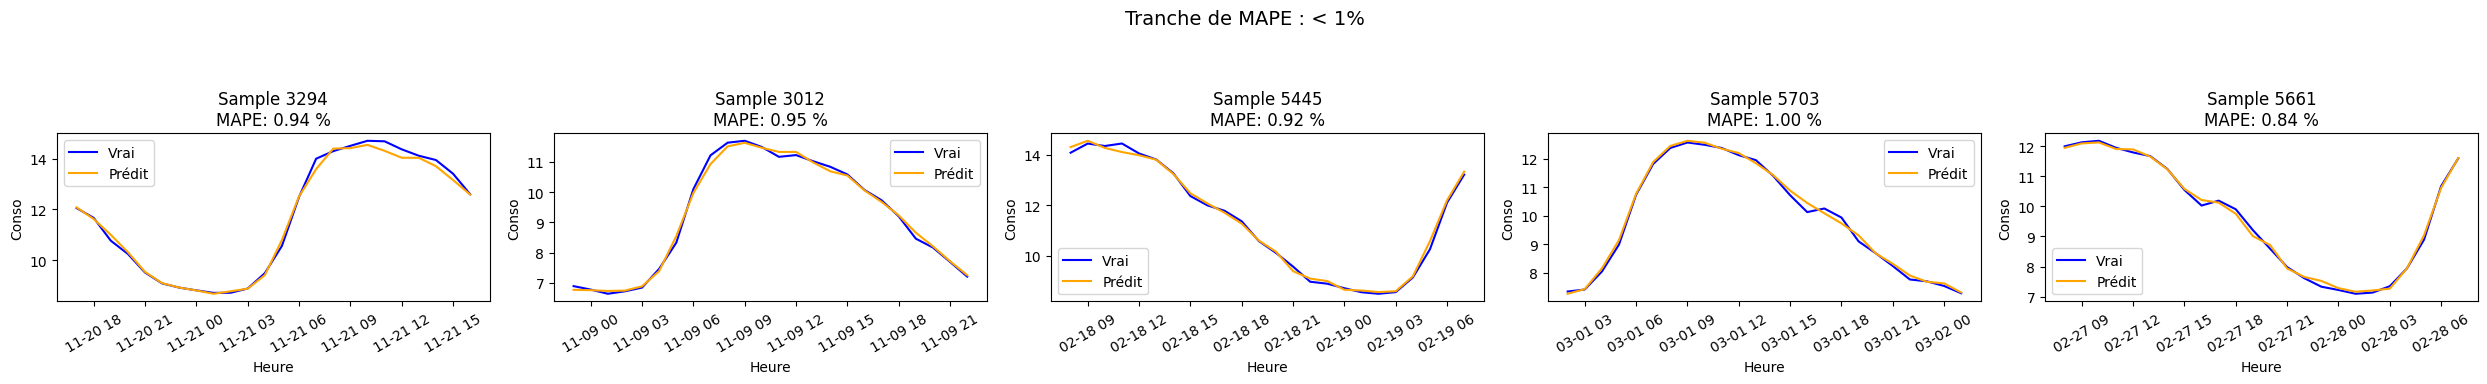

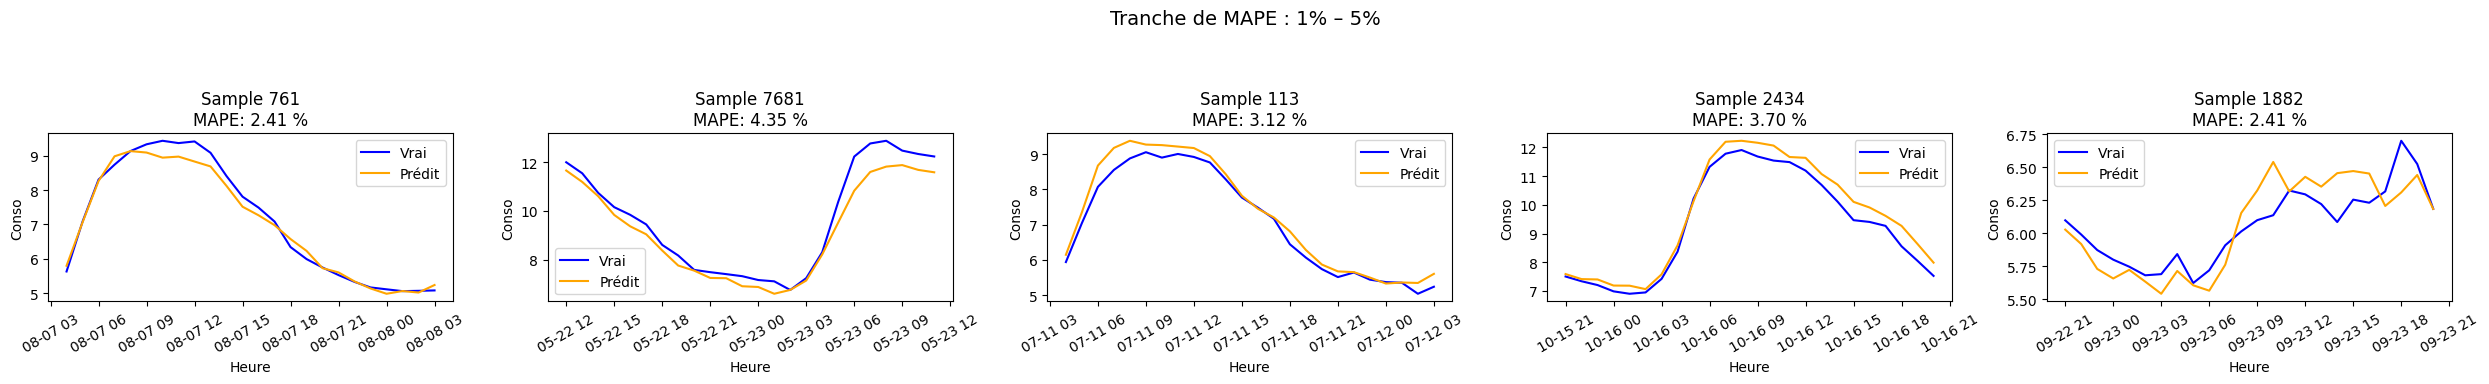

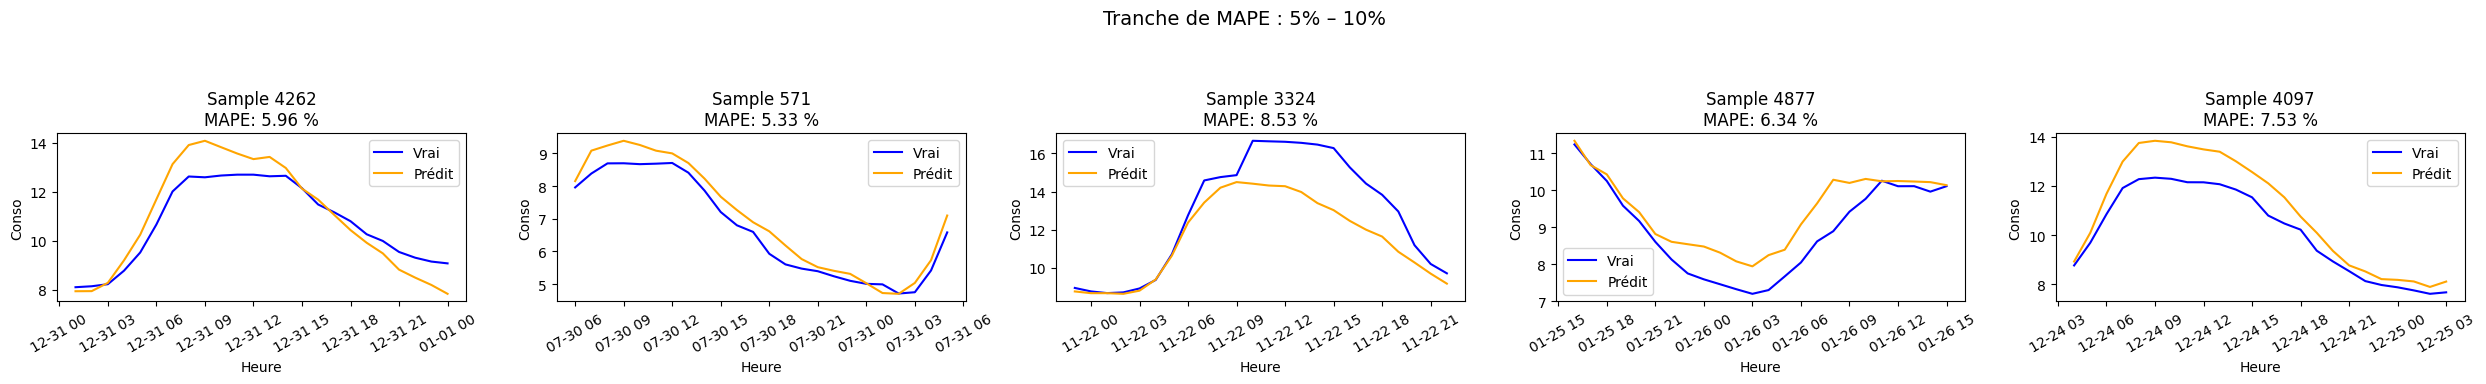

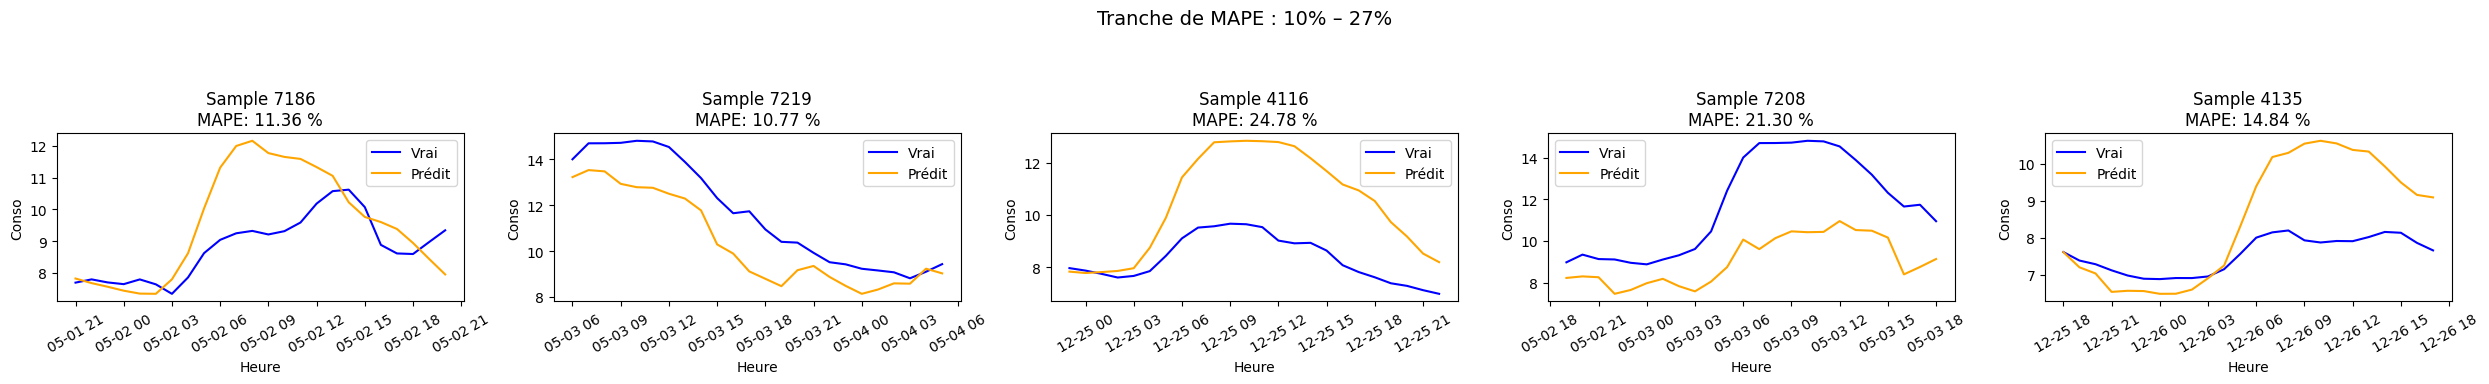

Aucun échantillon pour la tranche '≥ 27%'


In [51]:

# Calcul des MAPE
mape_scores = [mean_absolute_percentage_error(y_test_inversed[i], y_pred_inversed[i]) * 100 for i in range(len(y_test_inversed))]
 
# Tranches de MAPE
mape_bins = {
    "< 1%": [],  # Tranche pour MAPE < 1%
    "1% – 5%": [],     
    "5% – 10%": [],
    "10% – 27%": [],
    "≥ 27%": []
}
 
# Répartition des indices dans chaque tranche
for i, mape in enumerate(mape_scores):
    if mape < 1:
        mape_bins["< 1%"].append(i)    # Tranche pour MAPE < 1%
    elif mape < 5:
        mape_bins["1% – 5%"].append(i)
    elif mape < 10 :
        mape_bins["5% – 10%"].append(i)
    elif mape < 27 :
        mape_bins["10% – 27%"].append(i)
    else:
        mape_bins["≥ 27%"].append(i)
 
# Timestamps
try:
    timestamps = df_normalise.index[sequence_length + forecast_horizon:]
    timestamps_test = timestamps[X_test_indices]
    use_timestamps = True
except:
    print("Utilisation d'indices simples pour les timestamps")
    use_timestamps = False
 
# Affichage : 5 graphes par tranche
for category, indices in mape_bins.items():
    if len(indices) == 0:
        print(f"Aucun échantillon pour la tranche '{category}'")   # Skip if no samples in this category
        continue
 
    sample_indices = random.sample(indices, min(5, len(indices)))   # Sélection aléatoire de 5 échantillons ou moins si moins d'échantillons disponibles
 
    fig, axes = plt.subplots(1, len(sample_indices), figsize=(5 * len(sample_indices), 4))      # Create subplots for each sample
    fig.suptitle(f"Tranche de MAPE : {category}", fontsize=14)       # Title for the entire figure
 
    # S'assurer que axes est itérable
    if len(sample_indices) == 1:
        axes = [axes]
 
    for ax, idx in zip(axes, sample_indices):
        start_time = timestamps_test[idx]
        hours = [start_time + pd.Timedelta(hours=h) for h in range(forecast_horizon)]   # Generate hours for the x-axis
 
        ax.plot(hours, y_test_inversed[idx], label='Vrai', color='blue')
        ax.plot(hours, y_pred_inversed[idx], label='Prédit', color='orange')
        ax.set_title(f"Sample {idx}\nMAPE: {mape_scores[idx]:.2f} %")
        ax.set_xlabel("Heure")
        ax.set_ylabel("Conso")
        ax.xaxis.set_tick_params(rotation=30)
 
        ax.legend()
 
    plt.tight_layout(rect=[0, 0.03, 1, 0.90])
    plt.show()

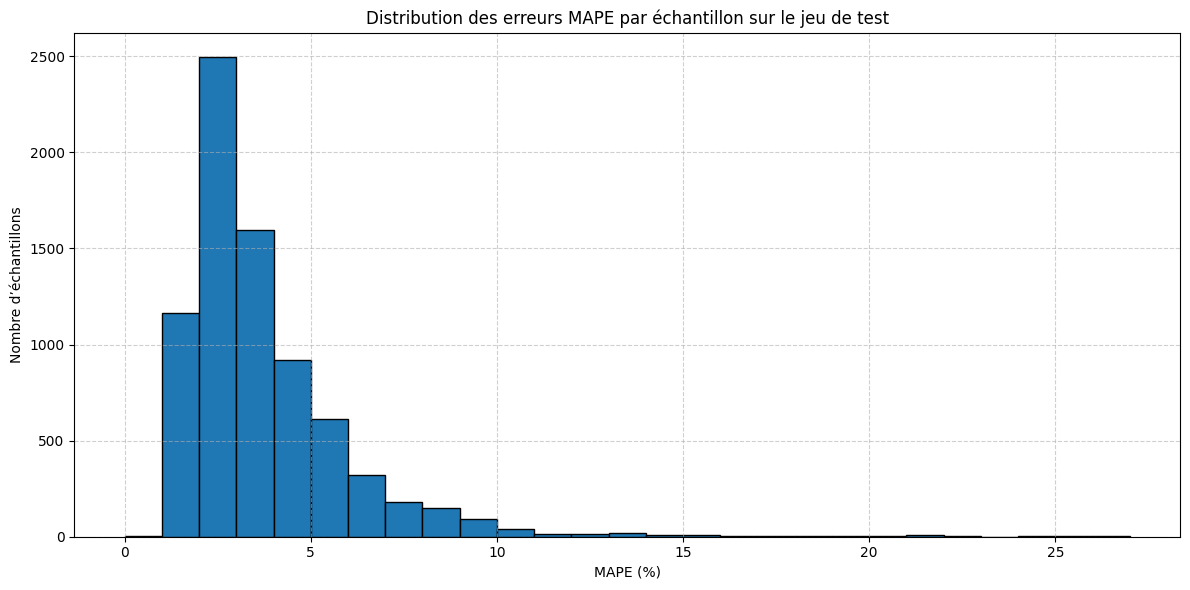

In [52]:

# Calcul du MAPE par échantillon
# Ici, on calcule le MAPE pour chaque échantillon et chaque horizon de prédiction
# puis on fait la moyenne sur l'horizon pour obtenir un score par échantillon
mape_per_sample = np.mean(np.abs((y_test_inversed - y_pred_inversed) / (y_test_inversed + 1e-8)) * 100, axis=1)

#  Regroupement des MAPE en intervalles (bins)
bins = np.arange(0, np.ceil(mape_per_sample.max()) +1 , 1)

# Tracer l’histogramme
plt.figure(figsize=(12, 6))
plt.hist(mape_per_sample, bins=bins, edgecolor='black')
plt.xlabel("MAPE (%)")
plt.ylabel("Nombre d’échantillons")
plt.title("Distribution des erreurs MAPE par échantillon sur le jeu de test")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [53]:
dates_test = df_business_consumption.loc[X_test_indices, "Date"]     # Get the dates corresponding to the test set indices

C:\Users\emac\AppData\Local\Temp\ipykernel_1196\3364321957.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby("MAPE_bin").size()


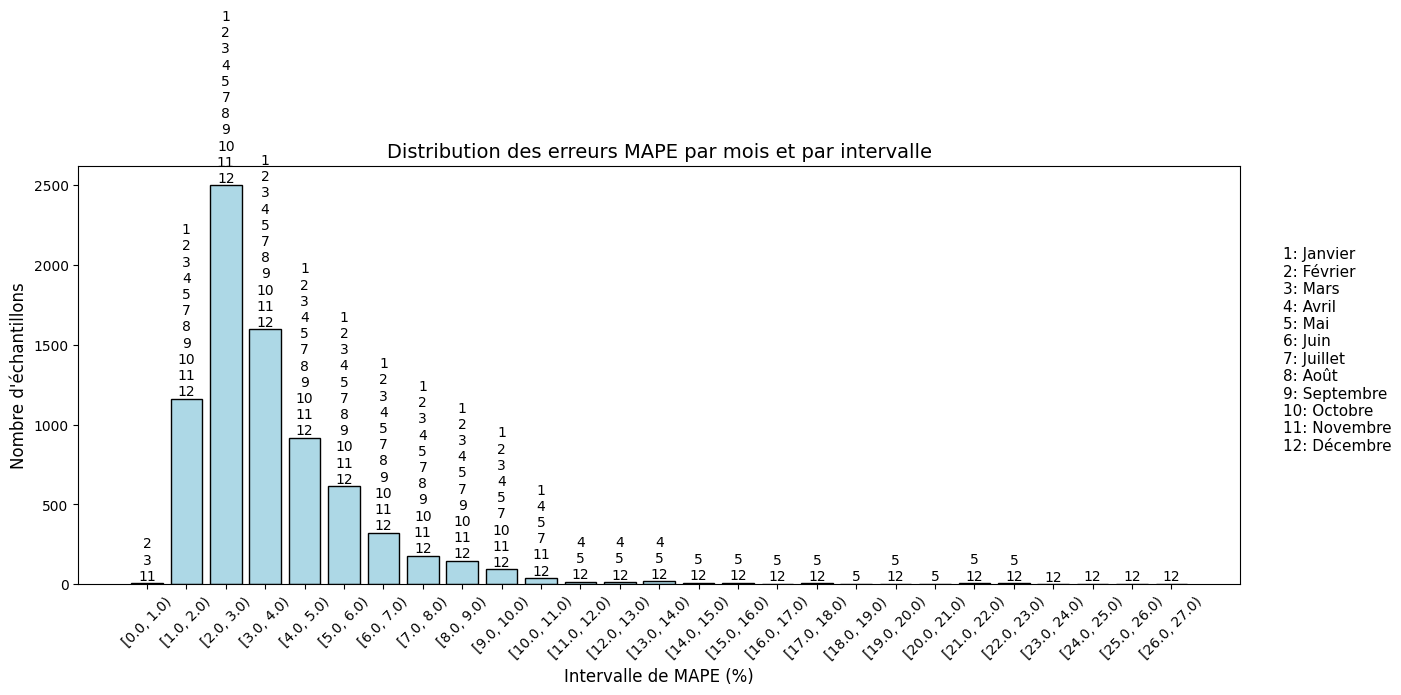

In [54]:
# Convertir timestamps en datetime si ce n'est pas déjà fait
timestamps_test = pd.to_datetime(timestamps_test)

#  Pour chaque timestamp, extraire tous les mois couverts par l'horizon de 24h
mois_par_sample = []
for t in timestamps_test:
    # Générer la série horaire pour l'horizon
    dates_horizon = pd.date_range(start=t, periods=forecast_horizon, freq='h')
    # Extraire les mois uniques
    mois = dates_horizon.month.unique()
    mois_par_sample.append(mois)

#  Créer les intervalles de MAPE (par exemple 1%)
bins = np.arange(0, np.ceil(mape_per_sample.max()) + 1, 1)

#  Construire DataFrame
df = pd.DataFrame({
    "MAPE": mape_per_sample,
    "Mois": mois_par_sample
})
df["MAPE_bin"] = pd.cut(df["MAPE"], bins=bins, right=False)

#  Grouper par bin pour compter les échantillons
df_grouped = df.groupby("MAPE_bin").size()

#  Plot
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(df_grouped.index.astype(str), df_grouped.values, edgecolor='black', color='lightblue')

#  Ajouter tous les mois (aplatir les listes) au-dessus des barres
for i, bin_label in enumerate(df_grouped.index):
    mois_listes = df.loc[df["MAPE_bin"] == bin_label, "Mois"]
    # Aplatir les listes et extraire les mois uniques
    tous_les_mois = sorted(set(m for sous_liste in mois_listes for m in sous_liste))
    mois_str = "\n".join(str(m) for m in tous_les_mois)
    ax.text(i, df_grouped.values[i] + 1, mois_str, ha='center', va='bottom', fontsize=10, color='black')

#  Mise en forme
ax.set_title("Distribution des erreurs MAPE par mois et par intervalle", fontsize=14)
ax.set_xlabel("Intervalle de MAPE (%)", fontsize=12)
ax.set_ylabel("Nombre d'échantillons", fontsize=12)
plt.xticks(rotation=45)

# Légende mois à droite
mois_legende = "\n".join([
    "1: Janvier", "2: Février", "3: Mars", "4: Avril",
    "5: Mai", "6: Juin", "7: Juillet", "8: Août",
    "9: Septembre", "10: Octobre", "11: Novembre", "12: Décembre"
])
plt.gcf().text(0.92, 0.5, mois_legende, fontsize=11, va='center')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

C:\Users\emac\AppData\Local\Temp\ipykernel_1196\2631605013.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby("MAPE_bin").size()


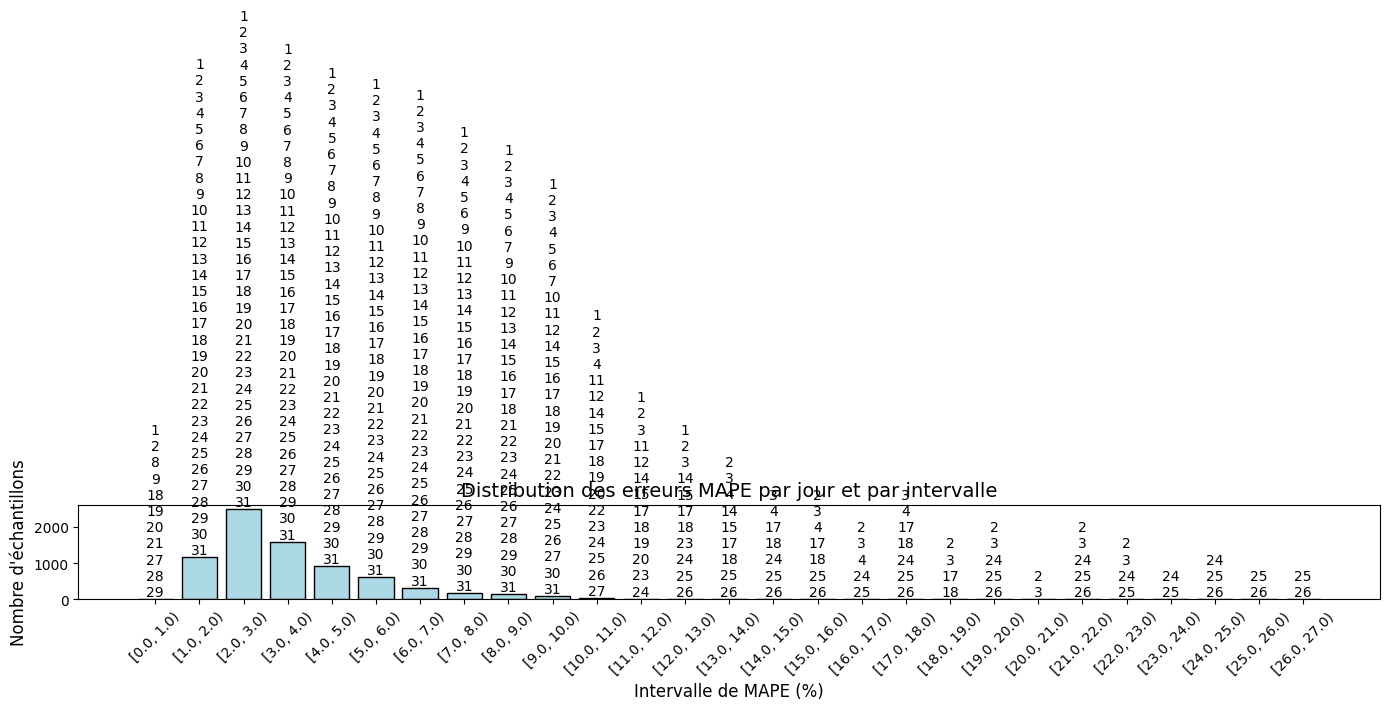

In [55]:


timestamps_test = pd.to_datetime(timestamps_test)

# Extraire tous les jours (numéro du jour dans le mois) couverts par chaque horizon
jours_par_sample = []
for t in timestamps_test:
    dates_horizon = pd.date_range(start=t, periods=forecast_horizon, freq='h')
    jours = dates_horizon.day.unique()  # jours dans le mois
    jours_par_sample.append(jours)

# Intervalles de MAPE (ajuste selon ton max MAPE)
bins = np.arange(0, np.ceil(mape_per_sample.max()) + 1, 1)

# DataFrame avec MAPE et jours multiples
df = pd.DataFrame({
    "MAPE": mape_per_sample,
    "Jours": jours_par_sample
})
df["MAPE_bin"] = pd.cut(df["MAPE"], bins=bins, right=False)

# Compter les échantillons par intervalle
df_grouped = df.groupby("MAPE_bin").size()

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(df_grouped.index.astype(str), df_grouped.values, edgecolor='black', color='lightblue')

# Ajouter les jours uniques au-dessus des barres
for i, bin_label in enumerate(df_grouped.index):
    jours_listes = df.loc[df["MAPE_bin"] == bin_label, "Jours"]
    tous_les_jours = sorted(set(j for sous_liste in jours_listes for j in sous_liste))
    jours_str = "\n".join(str(j) for j in tous_les_jours)
    ax.text(i, df_grouped.values[i] + 1, jours_str, ha='center', va='bottom', fontsize=10, color='black')

# Mise en forme
ax.set_title("Distribution des erreurs MAPE par jour et par intervalle", fontsize=14)
ax.set_xlabel("Intervalle de MAPE (%)", fontsize=12)
ax.set_ylabel("Nombre d'échantillons", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


C:\Users\emac\AppData\Local\Temp\ipykernel_1196\2188255723.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby("MAPE_bin").size()


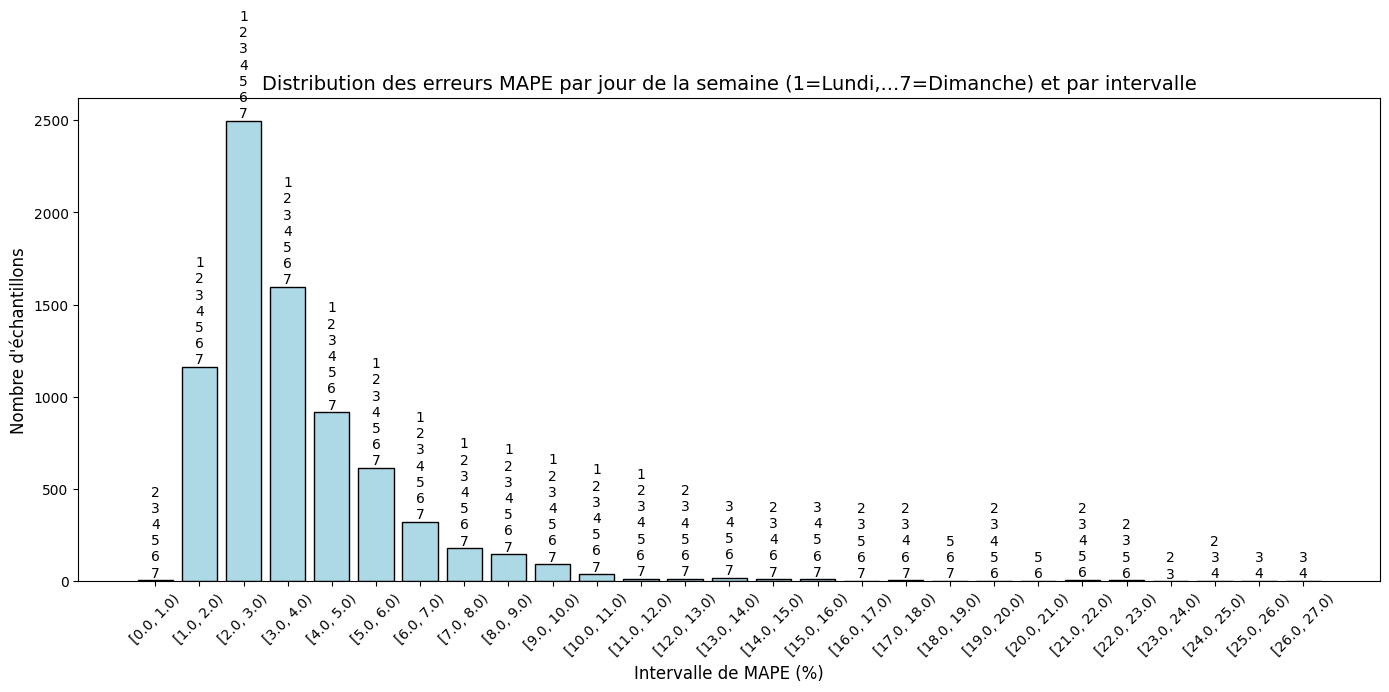

In [56]:


timestamps_test = pd.to_datetime(timestamps_test)    # Convertir les timestamps en datetime si ce n'est pas déjà fait

# Extraire les jours de la semaine couverts par chaque horizon (1=Lundi ... 7=Dimanche)
jours_sem_par_sample = []
for t in timestamps_test:
    dates_horizon = pd.date_range(start=t, periods=forecast_horizon, freq='h')
    jours_idx = dates_horizon.dayofweek.unique()  # 0=Lundi ... 6=Dimanche
    # Convertir en 1-7
    jours_chiffres = [j + 1 for j in jours_idx]
    jours_sem_par_sample.append(jours_chiffres)

# Intervalles de MAPE
bins = np.arange(0, np.ceil(mape_per_sample.max()) + 1, 1)

# DataFrame avec MAPE et jours de la semaine multiples
df = pd.DataFrame({
    "MAPE": mape_per_sample,
    "Jours_semaine": jours_sem_par_sample
})
df["MAPE_bin"] = pd.cut(df["MAPE"], bins=bins, right=False)

# Compter les échantillons par intervalle
df_grouped = df.groupby("MAPE_bin").size()

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(df_grouped.index.astype(str), df_grouped.values, edgecolor='black', color='lightblue')

# Ajouter les jours de la semaine uniques (chiffres) au-dessus des barres
for i, bin_label in enumerate(df_grouped.index):
    jours_listes = df.loc[df["MAPE_bin"] == bin_label, "Jours_semaine"]
    tous_les_jours = sorted(set(j for sous_liste in jours_listes for j in sous_liste))
    jours_str = "\n".join(str(j) for j in tous_les_jours)
    ax.text(i, df_grouped.values[i] + 1, jours_str, ha='center', va='bottom', fontsize=10, color='black')

# Mise en forme
ax.set_title("Distribution des erreurs MAPE par jour de la semaine (1=Lundi,...7=Dimanche) et par intervalle", fontsize=14)  
ax.set_xlabel("Intervalle de MAPE (%)", fontsize=12)
ax.set_ylabel("Nombre d'échantillons", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [57]:
# Analyse des résultats obtenus
# On les aplatit pour comparer globalement les distributions
y_test_flat = y_test_inversed.flatten()
y_pred_flat = y_pred_inversed.flatten()

# Création d'un DataFrame pour faciliter la comparaison
df_stats = pd.DataFrame({
    'Réel (y_test)': y_test_flat,
    'Prédit (y_pred)': y_pred_flat,
    'Erreur absolue': np.abs(y_test_flat - y_pred_flat),
    'Erreur relative (%)': 100 * np.abs(y_test_flat - y_pred_flat) / y_test_flat
})

# Calcul des statistiques descriptives
summary_stats = df_stats[['Réel (y_test)', 'Prédit (y_pred)', 'Erreur absolue', 'Erreur relative (%)']].describe().T
summary_stats = summary_stats.rename(columns={
    'mean': 'Moyenne',
    'std': 'Écart-type',
    'min': 'Min',
    '25%': 'Q1',
    '50%': 'Médiane',
    '75%': 'Q3',
    'max': 'Max'
})

# Affichage du tableau
print("Résumé statistique comparatif entre y_test et y_pred :")
display(summary_stats.round(2))


Résumé statistique comparatif entre y_test et y_pred :


,count,Moyenne,Écart-type,Min,Q1,Médiane,Q3,Max
Réel (y_test),184392.0,8.83,2.30,4.24,7.13,8.49,10.32,16.66
Prédit (y_pred),184392.0,8.86,2.29,3.63,7.16,8.55,10.34,16.35
Erreur absolue,184392.0,0.33,0.36,0.00,0.11,0.24,0.44,5.65
Erreur relative (%),184392.0,3.76,3.70,0.00,1.29,2.81,5.07,42.38
